# ImageCLEF Medical Caption Task 2019

The Image CLEF 2019 Concept Detection Task is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by Unified Medical Language System (UMLS) concept IDs.

The AUEB NLP Group won the competition with this paper. This assignment was prepared by Vasiliki Kougia and John Pavlopoulos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#preferred style
plt.style.use('ggplot')

import numpy as np
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

Using TensorFlow backend.


Read the labels

In [106]:
string_consepts = 'ImageCLEF2019/string_concepts.csv'
train_consepts = 'ImageCLEF2019/train_concepts.csv'
val_concepts = 'ImageCLEF2019/val_concepts.csv'

str_con = pd.read_csv(string_consepts, sep='\t', header=None)
train_con = pd.read_csv(train_consepts)
val_con = pd.read_csv(val_concepts)

In [4]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


Let's plot some images

In [5]:
training_set = 'ImageCLEF2019/training-set/'
test_set = 'ImageCLEF2019/test-set/'
validation_set = 'ImageCLEF2019/validation-set/'

In [6]:
train = []

time1 = time.time()   # to measure time taken

# Load in the images
for filepath in os.listdir(training_set):
    instances = cv2.imread(training_set + filepath, 0)
    train.append(instances)
    
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# train = np.array(train, dtype="float") / 255.0

Time taken: 192.0 seconds


In [7]:
train[2].shape

(504, 539)

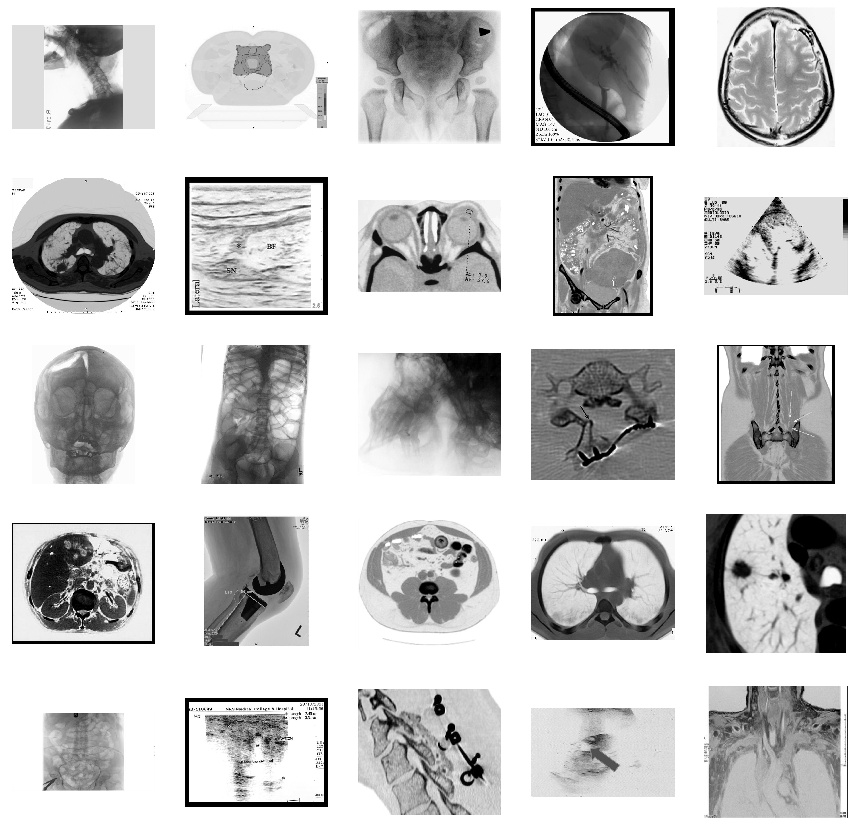

In [36]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)

In [33]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


In [126]:
str_con.rename(columns={0: 'tag', 1: 'tag_name'}, inplace=True)

In [144]:
str_con.loc[, :]

tag                       C1444197
tag_name    entire hyoid apparatus
Name: 123, dtype: object

In [130]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


In [174]:
def fetch_tags(tag):
    tags = tag.split(';')
    result = []
    for tag in tags:
        index = str_con.loc[str_con.tag == tag]
        result.append(index.tag_name.values[0])
    return result

In [179]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


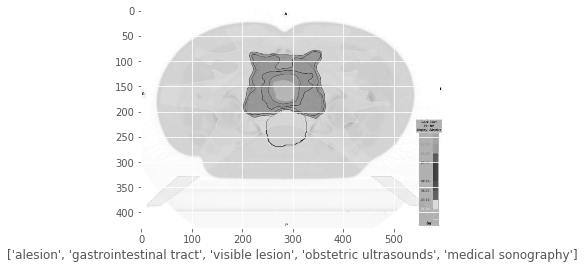

In [182]:
plt.imshow(train[1], cmap=plt.cm.binary)
tags = fetch_tags(train_con.iloc[1, 1])
_ = plt.xlabel(tags)

In [13]:
str_con.shape

(5528, 2)

In [27]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


In [89]:
columns = list(str_con.iloc[:, 0])
index = list(train_con.iloc[:, 0])

In [90]:
train_tagframe = pd.DataFrame(columns=columns, index=index)

In [91]:
train_tagframe

,C0032143,C0225516,C0825429,C0020461,C0947912,C0700164,C0935912,C0334467,C0334460,C0040578,...,C0567198,C0553702,C0028945,C1510755,C3151530,C0044955,C3812869,C2751430,C0441621,C0237886
ROCO_CLEF_07350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_19073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_60501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_05564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_55020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ROCO_CLEF_40405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_17150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_04341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROCO_CLEF_36569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
tags

0                                        C0203126;C0203051
1        [C0772294, C0023884, C0221198, C0412555, C0041...
2                      C0233492;C2985494;C0262950;C1306232
3                                        C0521530;C0817096
4                                        C0935598;C1184743
                               ...                        
56624                  C0040395;C0034579;C0015450;C0040405
56625                                    C0286840;C3244287
56626    C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627                           C0023890;C0441633;C3263723
56628    C3263723;C1962945;C1548003;C0015252;C0043250;C...
Name: tags, Length: 56629, dtype: object

In [110]:
tags = train_con.iloc[:, 1]

In [111]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


In [112]:
# for i, v in enumerate(index):
#     list_tags = tags[i].split(';')
#     for item in list_tags:
#         train_tagframe.loc[v, str(item)] == 1
#     print("Finish index: ", i)

Finish index:  0
Finish index:  1
Finish index:  2
Finish index:  3
Finish index:  4
Finish index:  5
Finish index:  6
Finish index:  7
Finish index:  8
Finish index:  9
Finish index:  10
Finish index:  11
Finish index:  12
Finish index:  13
Finish index:  14
Finish index:  15
Finish index:  16
Finish index:  17
Finish index:  18
Finish index:  19
Finish index:  20
Finish index:  21
Finish index:  22
Finish index:  23
Finish index:  24
Finish index:  25
Finish index:  26
Finish index:  27
Finish index:  28
Finish index:  29
Finish index:  30
Finish index:  31
Finish index:  32
Finish index:  33
Finish index:  34
Finish index:  35
Finish index:  36
Finish index:  37
Finish index:  38
Finish index:  39
Finish index:  40
Finish index:  41
Finish index:  42
Finish index:  43
Finish index:  44
Finish index:  45
Finish index:  46
Finish index:  47
Finish index:  48
Finish index:  49
Finish index:  50
Finish index:  51
Finish index:  52
Finish index:  53
Finish index:  54
Finish index:  55
Fi

Finish index:  462
Finish index:  463
Finish index:  464
Finish index:  465
Finish index:  466
Finish index:  467
Finish index:  468
Finish index:  469
Finish index:  470
Finish index:  471
Finish index:  472
Finish index:  473
Finish index:  474
Finish index:  475
Finish index:  476
Finish index:  477
Finish index:  478
Finish index:  479
Finish index:  480
Finish index:  481
Finish index:  482
Finish index:  483
Finish index:  484
Finish index:  485
Finish index:  486
Finish index:  487
Finish index:  488
Finish index:  489
Finish index:  490
Finish index:  491
Finish index:  492
Finish index:  493
Finish index:  494
Finish index:  495
Finish index:  496
Finish index:  497
Finish index:  498
Finish index:  499
Finish index:  500
Finish index:  501
Finish index:  502
Finish index:  503
Finish index:  504
Finish index:  505
Finish index:  506
Finish index:  507
Finish index:  508
Finish index:  509
Finish index:  510
Finish index:  511
Finish index:  512
Finish index:  513
Finish index

Finish index:  1112
Finish index:  1113
Finish index:  1114
Finish index:  1115
Finish index:  1116
Finish index:  1117
Finish index:  1118
Finish index:  1119
Finish index:  1120
Finish index:  1121
Finish index:  1122
Finish index:  1123
Finish index:  1124
Finish index:  1125
Finish index:  1126
Finish index:  1127
Finish index:  1128
Finish index:  1129
Finish index:  1130
Finish index:  1131
Finish index:  1132
Finish index:  1133
Finish index:  1134
Finish index:  1135
Finish index:  1136
Finish index:  1137
Finish index:  1138
Finish index:  1139
Finish index:  1140
Finish index:  1141
Finish index:  1142
Finish index:  1143
Finish index:  1144
Finish index:  1145
Finish index:  1146
Finish index:  1147
Finish index:  1148
Finish index:  1149
Finish index:  1150
Finish index:  1151
Finish index:  1152
Finish index:  1153
Finish index:  1154
Finish index:  1155
Finish index:  1156
Finish index:  1157
Finish index:  1158
Finish index:  1159
Finish index:  1160
Finish index:  1161


Finish index:  1704
Finish index:  1705
Finish index:  1706
Finish index:  1707
Finish index:  1708
Finish index:  1709
Finish index:  1710
Finish index:  1711
Finish index:  1712
Finish index:  1713
Finish index:  1714
Finish index:  1715
Finish index:  1716
Finish index:  1717
Finish index:  1718
Finish index:  1719
Finish index:  1720
Finish index:  1721
Finish index:  1722
Finish index:  1723
Finish index:  1724
Finish index:  1725
Finish index:  1726
Finish index:  1727
Finish index:  1728
Finish index:  1729
Finish index:  1730
Finish index:  1731
Finish index:  1732
Finish index:  1733
Finish index:  1734
Finish index:  1735
Finish index:  1736
Finish index:  1737
Finish index:  1738
Finish index:  1739
Finish index:  1740
Finish index:  1741
Finish index:  1742
Finish index:  1743
Finish index:  1744
Finish index:  1745
Finish index:  1746
Finish index:  1747
Finish index:  1748
Finish index:  1749
Finish index:  1750
Finish index:  1751
Finish index:  1752
Finish index:  1753


Finish index:  2191
Finish index:  2192
Finish index:  2193
Finish index:  2194
Finish index:  2195
Finish index:  2196
Finish index:  2197
Finish index:  2198
Finish index:  2199
Finish index:  2200
Finish index:  2201
Finish index:  2202
Finish index:  2203
Finish index:  2204
Finish index:  2205
Finish index:  2206
Finish index:  2207
Finish index:  2208
Finish index:  2209
Finish index:  2210
Finish index:  2211
Finish index:  2212
Finish index:  2213
Finish index:  2214
Finish index:  2215
Finish index:  2216
Finish index:  2217
Finish index:  2218
Finish index:  2219
Finish index:  2220
Finish index:  2221
Finish index:  2222
Finish index:  2223
Finish index:  2224
Finish index:  2225
Finish index:  2226
Finish index:  2227
Finish index:  2228
Finish index:  2229
Finish index:  2230
Finish index:  2231
Finish index:  2232
Finish index:  2233
Finish index:  2234
Finish index:  2235
Finish index:  2236
Finish index:  2237
Finish index:  2238
Finish index:  2239
Finish index:  2240


Finish index:  2825
Finish index:  2826
Finish index:  2827
Finish index:  2828
Finish index:  2829
Finish index:  2830
Finish index:  2831
Finish index:  2832
Finish index:  2833
Finish index:  2834
Finish index:  2835
Finish index:  2836
Finish index:  2837
Finish index:  2838
Finish index:  2839
Finish index:  2840
Finish index:  2841
Finish index:  2842
Finish index:  2843
Finish index:  2844
Finish index:  2845
Finish index:  2846
Finish index:  2847
Finish index:  2848
Finish index:  2849
Finish index:  2850
Finish index:  2851
Finish index:  2852
Finish index:  2853
Finish index:  2854
Finish index:  2855
Finish index:  2856
Finish index:  2857
Finish index:  2858
Finish index:  2859
Finish index:  2860
Finish index:  2861
Finish index:  2862
Finish index:  2863
Finish index:  2864
Finish index:  2865
Finish index:  2866
Finish index:  2867
Finish index:  2868
Finish index:  2869
Finish index:  2870
Finish index:  2871
Finish index:  2872
Finish index:  2873
Finish index:  2874


Finish index:  3365
Finish index:  3366
Finish index:  3367
Finish index:  3368
Finish index:  3369
Finish index:  3370
Finish index:  3371
Finish index:  3372
Finish index:  3373
Finish index:  3374
Finish index:  3375
Finish index:  3376
Finish index:  3377
Finish index:  3378
Finish index:  3379
Finish index:  3380
Finish index:  3381
Finish index:  3382
Finish index:  3383
Finish index:  3384
Finish index:  3385
Finish index:  3386
Finish index:  3387
Finish index:  3388
Finish index:  3389
Finish index:  3390
Finish index:  3391
Finish index:  3392
Finish index:  3393
Finish index:  3394
Finish index:  3395
Finish index:  3396
Finish index:  3397
Finish index:  3398
Finish index:  3399
Finish index:  3400
Finish index:  3401
Finish index:  3402
Finish index:  3403
Finish index:  3404
Finish index:  3405
Finish index:  3406
Finish index:  3407
Finish index:  3408
Finish index:  3409
Finish index:  3410
Finish index:  3411
Finish index:  3412
Finish index:  3413
Finish index:  3414


Finish index:  3947
Finish index:  3948
Finish index:  3949
Finish index:  3950
Finish index:  3951
Finish index:  3952
Finish index:  3953
Finish index:  3954
Finish index:  3955
Finish index:  3956
Finish index:  3957
Finish index:  3958
Finish index:  3959
Finish index:  3960
Finish index:  3961
Finish index:  3962
Finish index:  3963
Finish index:  3964
Finish index:  3965
Finish index:  3966
Finish index:  3967
Finish index:  3968
Finish index:  3969
Finish index:  3970
Finish index:  3971
Finish index:  3972
Finish index:  3973
Finish index:  3974
Finish index:  3975
Finish index:  3976
Finish index:  3977
Finish index:  3978
Finish index:  3979
Finish index:  3980
Finish index:  3981
Finish index:  3982
Finish index:  3983
Finish index:  3984
Finish index:  3985
Finish index:  3986
Finish index:  3987
Finish index:  3988
Finish index:  3989
Finish index:  3990
Finish index:  3991
Finish index:  3992
Finish index:  3993
Finish index:  3994
Finish index:  3995
Finish index:  3996


Finish index:  4375
Finish index:  4376
Finish index:  4377
Finish index:  4378
Finish index:  4379
Finish index:  4380
Finish index:  4381
Finish index:  4382
Finish index:  4383
Finish index:  4384
Finish index:  4385
Finish index:  4386
Finish index:  4387
Finish index:  4388
Finish index:  4389
Finish index:  4390
Finish index:  4391
Finish index:  4392
Finish index:  4393
Finish index:  4394
Finish index:  4395
Finish index:  4396
Finish index:  4397
Finish index:  4398
Finish index:  4399
Finish index:  4400
Finish index:  4401
Finish index:  4402
Finish index:  4403
Finish index:  4404
Finish index:  4405
Finish index:  4406
Finish index:  4407
Finish index:  4408
Finish index:  4409
Finish index:  4410
Finish index:  4411
Finish index:  4412
Finish index:  4413
Finish index:  4414
Finish index:  4415
Finish index:  4416
Finish index:  4417
Finish index:  4418
Finish index:  4419
Finish index:  4420
Finish index:  4421
Finish index:  4422
Finish index:  4423
Finish index:  4424


Finish index:  4835
Finish index:  4836
Finish index:  4837
Finish index:  4838
Finish index:  4839
Finish index:  4840
Finish index:  4841
Finish index:  4842
Finish index:  4843
Finish index:  4844
Finish index:  4845
Finish index:  4846
Finish index:  4847
Finish index:  4848
Finish index:  4849
Finish index:  4850
Finish index:  4851
Finish index:  4852
Finish index:  4853
Finish index:  4854
Finish index:  4855
Finish index:  4856
Finish index:  4857
Finish index:  4858
Finish index:  4859
Finish index:  4860
Finish index:  4861
Finish index:  4862
Finish index:  4863
Finish index:  4864
Finish index:  4865
Finish index:  4866
Finish index:  4867
Finish index:  4868
Finish index:  4869
Finish index:  4870
Finish index:  4871
Finish index:  4872
Finish index:  4873
Finish index:  4874
Finish index:  4875
Finish index:  4876
Finish index:  4877
Finish index:  4878
Finish index:  4879
Finish index:  4880
Finish index:  4881
Finish index:  4882
Finish index:  4883
Finish index:  4884


Finish index:  5273
Finish index:  5274
Finish index:  5275
Finish index:  5276
Finish index:  5277
Finish index:  5278
Finish index:  5279
Finish index:  5280
Finish index:  5281
Finish index:  5282
Finish index:  5283
Finish index:  5284
Finish index:  5285
Finish index:  5286
Finish index:  5287
Finish index:  5288
Finish index:  5289
Finish index:  5290
Finish index:  5291
Finish index:  5292
Finish index:  5293
Finish index:  5294
Finish index:  5295
Finish index:  5296
Finish index:  5297
Finish index:  5298
Finish index:  5299
Finish index:  5300
Finish index:  5301
Finish index:  5302
Finish index:  5303
Finish index:  5304
Finish index:  5305
Finish index:  5306
Finish index:  5307
Finish index:  5308
Finish index:  5309
Finish index:  5310
Finish index:  5311
Finish index:  5312
Finish index:  5313
Finish index:  5314
Finish index:  5315
Finish index:  5316
Finish index:  5317
Finish index:  5318
Finish index:  5319
Finish index:  5320
Finish index:  5321
Finish index:  5322


Finish index:  5682
Finish index:  5683
Finish index:  5684
Finish index:  5685
Finish index:  5686
Finish index:  5687
Finish index:  5688
Finish index:  5689
Finish index:  5690
Finish index:  5691
Finish index:  5692
Finish index:  5693
Finish index:  5694
Finish index:  5695
Finish index:  5696
Finish index:  5697
Finish index:  5698
Finish index:  5699
Finish index:  5700
Finish index:  5701
Finish index:  5702
Finish index:  5703
Finish index:  5704
Finish index:  5705
Finish index:  5706
Finish index:  5707
Finish index:  5708
Finish index:  5709
Finish index:  5710
Finish index:  5711
Finish index:  5712
Finish index:  5713
Finish index:  5714
Finish index:  5715
Finish index:  5716
Finish index:  5717
Finish index:  5718
Finish index:  5719
Finish index:  5720
Finish index:  5721
Finish index:  5722
Finish index:  5723
Finish index:  5724
Finish index:  5725
Finish index:  5726
Finish index:  5727
Finish index:  5728
Finish index:  5729
Finish index:  5730
Finish index:  5731


Finish index:  6169
Finish index:  6170
Finish index:  6171
Finish index:  6172
Finish index:  6173
Finish index:  6174
Finish index:  6175
Finish index:  6176
Finish index:  6177
Finish index:  6178
Finish index:  6179
Finish index:  6180
Finish index:  6181
Finish index:  6182
Finish index:  6183
Finish index:  6184
Finish index:  6185
Finish index:  6186
Finish index:  6187
Finish index:  6188
Finish index:  6189
Finish index:  6190
Finish index:  6191
Finish index:  6192
Finish index:  6193
Finish index:  6194
Finish index:  6195
Finish index:  6196
Finish index:  6197
Finish index:  6198
Finish index:  6199
Finish index:  6200
Finish index:  6201
Finish index:  6202
Finish index:  6203
Finish index:  6204
Finish index:  6205
Finish index:  6206
Finish index:  6207
Finish index:  6208
Finish index:  6209
Finish index:  6210
Finish index:  6211
Finish index:  6212
Finish index:  6213
Finish index:  6214
Finish index:  6215
Finish index:  6216
Finish index:  6217
Finish index:  6218


Finish index:  6644
Finish index:  6645
Finish index:  6646
Finish index:  6647
Finish index:  6648
Finish index:  6649
Finish index:  6650
Finish index:  6651
Finish index:  6652
Finish index:  6653
Finish index:  6654
Finish index:  6655
Finish index:  6656
Finish index:  6657
Finish index:  6658
Finish index:  6659
Finish index:  6660
Finish index:  6661
Finish index:  6662
Finish index:  6663
Finish index:  6664
Finish index:  6665
Finish index:  6666
Finish index:  6667
Finish index:  6668
Finish index:  6669
Finish index:  6670
Finish index:  6671
Finish index:  6672
Finish index:  6673
Finish index:  6674
Finish index:  6675
Finish index:  6676
Finish index:  6677
Finish index:  6678
Finish index:  6679
Finish index:  6680
Finish index:  6681
Finish index:  6682
Finish index:  6683
Finish index:  6684
Finish index:  6685
Finish index:  6686
Finish index:  6687
Finish index:  6688
Finish index:  6689
Finish index:  6690
Finish index:  6691
Finish index:  6692
Finish index:  6693


Finish index:  7054
Finish index:  7055
Finish index:  7056
Finish index:  7057
Finish index:  7058
Finish index:  7059
Finish index:  7060
Finish index:  7061
Finish index:  7062
Finish index:  7063
Finish index:  7064
Finish index:  7065
Finish index:  7066
Finish index:  7067
Finish index:  7068
Finish index:  7069
Finish index:  7070
Finish index:  7071
Finish index:  7072
Finish index:  7073
Finish index:  7074
Finish index:  7075
Finish index:  7076
Finish index:  7077
Finish index:  7078
Finish index:  7079
Finish index:  7080
Finish index:  7081
Finish index:  7082
Finish index:  7083
Finish index:  7084
Finish index:  7085
Finish index:  7086
Finish index:  7087
Finish index:  7088
Finish index:  7089
Finish index:  7090
Finish index:  7091
Finish index:  7092
Finish index:  7093
Finish index:  7094
Finish index:  7095
Finish index:  7096
Finish index:  7097
Finish index:  7098
Finish index:  7099
Finish index:  7100
Finish index:  7101
Finish index:  7102
Finish index:  7103


Finish index:  7480
Finish index:  7481
Finish index:  7482
Finish index:  7483
Finish index:  7484
Finish index:  7485
Finish index:  7486
Finish index:  7487
Finish index:  7488
Finish index:  7489
Finish index:  7490
Finish index:  7491
Finish index:  7492
Finish index:  7493
Finish index:  7494
Finish index:  7495
Finish index:  7496
Finish index:  7497
Finish index:  7498
Finish index:  7499
Finish index:  7500
Finish index:  7501
Finish index:  7502
Finish index:  7503
Finish index:  7504
Finish index:  7505
Finish index:  7506
Finish index:  7507
Finish index:  7508
Finish index:  7509
Finish index:  7510
Finish index:  7511
Finish index:  7512
Finish index:  7513
Finish index:  7514
Finish index:  7515
Finish index:  7516
Finish index:  7517
Finish index:  7518
Finish index:  7519
Finish index:  7520
Finish index:  7521
Finish index:  7522
Finish index:  7523
Finish index:  7524
Finish index:  7525
Finish index:  7526
Finish index:  7527
Finish index:  7528
Finish index:  7529


Finish index:  7940
Finish index:  7941
Finish index:  7942
Finish index:  7943
Finish index:  7944
Finish index:  7945
Finish index:  7946
Finish index:  7947
Finish index:  7948
Finish index:  7949
Finish index:  7950
Finish index:  7951
Finish index:  7952
Finish index:  7953
Finish index:  7954
Finish index:  7955
Finish index:  7956
Finish index:  7957
Finish index:  7958
Finish index:  7959
Finish index:  7960
Finish index:  7961
Finish index:  7962
Finish index:  7963
Finish index:  7964
Finish index:  7965
Finish index:  7966
Finish index:  7967
Finish index:  7968
Finish index:  7969
Finish index:  7970
Finish index:  7971
Finish index:  7972
Finish index:  7973
Finish index:  7974
Finish index:  7975
Finish index:  7976
Finish index:  7977
Finish index:  7978
Finish index:  7979
Finish index:  7980
Finish index:  7981
Finish index:  7982
Finish index:  7983
Finish index:  7984
Finish index:  7985
Finish index:  7986
Finish index:  7987
Finish index:  7988
Finish index:  7989


Finish index:  8382
Finish index:  8383
Finish index:  8384
Finish index:  8385
Finish index:  8386
Finish index:  8387
Finish index:  8388
Finish index:  8389
Finish index:  8390
Finish index:  8391
Finish index:  8392
Finish index:  8393
Finish index:  8394
Finish index:  8395
Finish index:  8396
Finish index:  8397
Finish index:  8398
Finish index:  8399
Finish index:  8400
Finish index:  8401
Finish index:  8402
Finish index:  8403
Finish index:  8404
Finish index:  8405
Finish index:  8406
Finish index:  8407
Finish index:  8408
Finish index:  8409
Finish index:  8410
Finish index:  8411
Finish index:  8412
Finish index:  8413
Finish index:  8414
Finish index:  8415
Finish index:  8416
Finish index:  8417
Finish index:  8418
Finish index:  8419
Finish index:  8420
Finish index:  8421
Finish index:  8422
Finish index:  8423
Finish index:  8424
Finish index:  8425
Finish index:  8426
Finish index:  8427
Finish index:  8428
Finish index:  8429
Finish index:  8430
Finish index:  8431


Finish index:  8835
Finish index:  8836
Finish index:  8837
Finish index:  8838
Finish index:  8839
Finish index:  8840
Finish index:  8841
Finish index:  8842
Finish index:  8843
Finish index:  8844
Finish index:  8845
Finish index:  8846
Finish index:  8847
Finish index:  8848
Finish index:  8849
Finish index:  8850
Finish index:  8851
Finish index:  8852
Finish index:  8853
Finish index:  8854
Finish index:  8855
Finish index:  8856
Finish index:  8857
Finish index:  8858
Finish index:  8859
Finish index:  8860
Finish index:  8861
Finish index:  8862
Finish index:  8863
Finish index:  8864
Finish index:  8865
Finish index:  8866
Finish index:  8867
Finish index:  8868
Finish index:  8869
Finish index:  8870
Finish index:  8871
Finish index:  8872
Finish index:  8873
Finish index:  8874
Finish index:  8875
Finish index:  8876
Finish index:  8877
Finish index:  8878
Finish index:  8879
Finish index:  8880
Finish index:  8881
Finish index:  8882
Finish index:  8883
Finish index:  8884


Finish index:  9277
Finish index:  9278
Finish index:  9279
Finish index:  9280
Finish index:  9281
Finish index:  9282
Finish index:  9283
Finish index:  9284
Finish index:  9285
Finish index:  9286
Finish index:  9287
Finish index:  9288
Finish index:  9289
Finish index:  9290
Finish index:  9291
Finish index:  9292
Finish index:  9293
Finish index:  9294
Finish index:  9295
Finish index:  9296
Finish index:  9297
Finish index:  9298
Finish index:  9299
Finish index:  9300
Finish index:  9301
Finish index:  9302
Finish index:  9303
Finish index:  9304
Finish index:  9305
Finish index:  9306
Finish index:  9307
Finish index:  9308
Finish index:  9309
Finish index:  9310
Finish index:  9311
Finish index:  9312
Finish index:  9313
Finish index:  9314
Finish index:  9315
Finish index:  9316
Finish index:  9317
Finish index:  9318
Finish index:  9319
Finish index:  9320
Finish index:  9321
Finish index:  9322
Finish index:  9323
Finish index:  9324
Finish index:  9325
Finish index:  9326


Finish index:  9708
Finish index:  9709
Finish index:  9710
Finish index:  9711
Finish index:  9712
Finish index:  9713
Finish index:  9714
Finish index:  9715
Finish index:  9716
Finish index:  9717
Finish index:  9718
Finish index:  9719
Finish index:  9720
Finish index:  9721
Finish index:  9722
Finish index:  9723
Finish index:  9724
Finish index:  9725
Finish index:  9726
Finish index:  9727
Finish index:  9728
Finish index:  9729
Finish index:  9730
Finish index:  9731
Finish index:  9732
Finish index:  9733
Finish index:  9734
Finish index:  9735
Finish index:  9736
Finish index:  9737
Finish index:  9738
Finish index:  9739
Finish index:  9740
Finish index:  9741
Finish index:  9742
Finish index:  9743
Finish index:  9744
Finish index:  9745
Finish index:  9746
Finish index:  9747
Finish index:  9748
Finish index:  9749
Finish index:  9750
Finish index:  9751
Finish index:  9752
Finish index:  9753
Finish index:  9754
Finish index:  9755
Finish index:  9756
Finish index:  9757


Finish index:  10392
Finish index:  10393
Finish index:  10394
Finish index:  10395
Finish index:  10396
Finish index:  10397
Finish index:  10398
Finish index:  10399
Finish index:  10400
Finish index:  10401
Finish index:  10402
Finish index:  10403
Finish index:  10404
Finish index:  10405
Finish index:  10406
Finish index:  10407
Finish index:  10408
Finish index:  10409
Finish index:  10410
Finish index:  10411
Finish index:  10412
Finish index:  10413
Finish index:  10414
Finish index:  10415
Finish index:  10416
Finish index:  10417
Finish index:  10418
Finish index:  10419
Finish index:  10420
Finish index:  10421
Finish index:  10422
Finish index:  10423
Finish index:  10424
Finish index:  10425
Finish index:  10426
Finish index:  10427
Finish index:  10428
Finish index:  10429
Finish index:  10430
Finish index:  10431
Finish index:  10432
Finish index:  10433
Finish index:  10434
Finish index:  10435
Finish index:  10436
Finish index:  10437
Finish index:  10438
Finish index:

Finish index:  10807
Finish index:  10808
Finish index:  10809
Finish index:  10810
Finish index:  10811
Finish index:  10812
Finish index:  10813
Finish index:  10814
Finish index:  10815
Finish index:  10816
Finish index:  10817
Finish index:  10818
Finish index:  10819
Finish index:  10820
Finish index:  10821
Finish index:  10822
Finish index:  10823
Finish index:  10824
Finish index:  10825
Finish index:  10826
Finish index:  10827
Finish index:  10828
Finish index:  10829
Finish index:  10830
Finish index:  10831
Finish index:  10832
Finish index:  10833
Finish index:  10834
Finish index:  10835
Finish index:  10836
Finish index:  10837
Finish index:  10838
Finish index:  10839
Finish index:  10840
Finish index:  10841
Finish index:  10842
Finish index:  10843
Finish index:  10844
Finish index:  10845
Finish index:  10846
Finish index:  10847
Finish index:  10848
Finish index:  10849
Finish index:  10850
Finish index:  10851
Finish index:  10852
Finish index:  10853
Finish index:

Finish index:  11268
Finish index:  11269
Finish index:  11270
Finish index:  11271
Finish index:  11272
Finish index:  11273
Finish index:  11274
Finish index:  11275
Finish index:  11276
Finish index:  11277
Finish index:  11278
Finish index:  11279
Finish index:  11280
Finish index:  11281
Finish index:  11282
Finish index:  11283
Finish index:  11284
Finish index:  11285
Finish index:  11286
Finish index:  11287
Finish index:  11288
Finish index:  11289
Finish index:  11290
Finish index:  11291
Finish index:  11292
Finish index:  11293
Finish index:  11294
Finish index:  11295
Finish index:  11296
Finish index:  11297
Finish index:  11298
Finish index:  11299
Finish index:  11300
Finish index:  11301
Finish index:  11302
Finish index:  11303
Finish index:  11304
Finish index:  11305
Finish index:  11306
Finish index:  11307
Finish index:  11308
Finish index:  11309
Finish index:  11310
Finish index:  11311
Finish index:  11312
Finish index:  11313
Finish index:  11314
Finish index:

Finish index:  11780
Finish index:  11781
Finish index:  11782
Finish index:  11783
Finish index:  11784
Finish index:  11785
Finish index:  11786
Finish index:  11787
Finish index:  11788
Finish index:  11789
Finish index:  11790
Finish index:  11791
Finish index:  11792
Finish index:  11793
Finish index:  11794
Finish index:  11795
Finish index:  11796
Finish index:  11797
Finish index:  11798
Finish index:  11799
Finish index:  11800
Finish index:  11801
Finish index:  11802
Finish index:  11803
Finish index:  11804
Finish index:  11805
Finish index:  11806
Finish index:  11807
Finish index:  11808
Finish index:  11809
Finish index:  11810
Finish index:  11811
Finish index:  11812
Finish index:  11813
Finish index:  11814
Finish index:  11815
Finish index:  11816
Finish index:  11817
Finish index:  11818
Finish index:  11819
Finish index:  11820
Finish index:  11821
Finish index:  11822
Finish index:  11823
Finish index:  11824
Finish index:  11825
Finish index:  11826
Finish index:

Finish index:  12418
Finish index:  12419
Finish index:  12420
Finish index:  12421
Finish index:  12422
Finish index:  12423
Finish index:  12424
Finish index:  12425
Finish index:  12426
Finish index:  12427
Finish index:  12428
Finish index:  12429
Finish index:  12430
Finish index:  12431
Finish index:  12432
Finish index:  12433
Finish index:  12434
Finish index:  12435
Finish index:  12436
Finish index:  12437
Finish index:  12438
Finish index:  12439
Finish index:  12440
Finish index:  12441
Finish index:  12442
Finish index:  12443
Finish index:  12444
Finish index:  12445
Finish index:  12446
Finish index:  12447
Finish index:  12448
Finish index:  12449
Finish index:  12450
Finish index:  12451
Finish index:  12452
Finish index:  12453
Finish index:  12454
Finish index:  12455
Finish index:  12456
Finish index:  12457
Finish index:  12458
Finish index:  12459
Finish index:  12460
Finish index:  12461
Finish index:  12462
Finish index:  12463
Finish index:  12464
Finish index:

Finish index:  12964
Finish index:  12965
Finish index:  12966
Finish index:  12967
Finish index:  12968
Finish index:  12969
Finish index:  12970
Finish index:  12971
Finish index:  12972
Finish index:  12973
Finish index:  12974
Finish index:  12975
Finish index:  12976
Finish index:  12977
Finish index:  12978
Finish index:  12979
Finish index:  12980
Finish index:  12981
Finish index:  12982
Finish index:  12983
Finish index:  12984
Finish index:  12985
Finish index:  12986
Finish index:  12987
Finish index:  12988
Finish index:  12989
Finish index:  12990
Finish index:  12991
Finish index:  12992
Finish index:  12993
Finish index:  12994
Finish index:  12995
Finish index:  12996
Finish index:  12997
Finish index:  12998
Finish index:  12999
Finish index:  13000
Finish index:  13001
Finish index:  13002
Finish index:  13003
Finish index:  13004
Finish index:  13005
Finish index:  13006
Finish index:  13007
Finish index:  13008
Finish index:  13009
Finish index:  13010
Finish index:

Finish index:  13539
Finish index:  13540
Finish index:  13541
Finish index:  13542
Finish index:  13543
Finish index:  13544
Finish index:  13545
Finish index:  13546
Finish index:  13547
Finish index:  13548
Finish index:  13549
Finish index:  13550
Finish index:  13551
Finish index:  13552
Finish index:  13553
Finish index:  13554
Finish index:  13555
Finish index:  13556
Finish index:  13557
Finish index:  13558
Finish index:  13559
Finish index:  13560
Finish index:  13561
Finish index:  13562
Finish index:  13563
Finish index:  13564
Finish index:  13565
Finish index:  13566
Finish index:  13567
Finish index:  13568
Finish index:  13569
Finish index:  13570
Finish index:  13571
Finish index:  13572
Finish index:  13573
Finish index:  13574
Finish index:  13575
Finish index:  13576
Finish index:  13577
Finish index:  13578
Finish index:  13579
Finish index:  13580
Finish index:  13581
Finish index:  13582
Finish index:  13583
Finish index:  13584
Finish index:  13585
Finish index:

Finish index:  13945
Finish index:  13946
Finish index:  13947
Finish index:  13948
Finish index:  13949
Finish index:  13950
Finish index:  13951
Finish index:  13952
Finish index:  13953
Finish index:  13954
Finish index:  13955
Finish index:  13956
Finish index:  13957
Finish index:  13958
Finish index:  13959
Finish index:  13960
Finish index:  13961
Finish index:  13962
Finish index:  13963
Finish index:  13964
Finish index:  13965
Finish index:  13966
Finish index:  13967
Finish index:  13968
Finish index:  13969
Finish index:  13970
Finish index:  13971
Finish index:  13972
Finish index:  13973
Finish index:  13974
Finish index:  13975
Finish index:  13976
Finish index:  13977
Finish index:  13978
Finish index:  13979
Finish index:  13980
Finish index:  13981
Finish index:  13982
Finish index:  13983
Finish index:  13984
Finish index:  13985
Finish index:  13986
Finish index:  13987
Finish index:  13988
Finish index:  13989
Finish index:  13990
Finish index:  13991
Finish index:

Finish index:  14349
Finish index:  14350
Finish index:  14351
Finish index:  14352
Finish index:  14353
Finish index:  14354
Finish index:  14355
Finish index:  14356
Finish index:  14357
Finish index:  14358
Finish index:  14359
Finish index:  14360
Finish index:  14361
Finish index:  14362
Finish index:  14363
Finish index:  14364
Finish index:  14365
Finish index:  14366
Finish index:  14367
Finish index:  14368
Finish index:  14369
Finish index:  14370
Finish index:  14371
Finish index:  14372
Finish index:  14373
Finish index:  14374
Finish index:  14375
Finish index:  14376
Finish index:  14377
Finish index:  14378
Finish index:  14379
Finish index:  14380
Finish index:  14381
Finish index:  14382
Finish index:  14383
Finish index:  14384
Finish index:  14385
Finish index:  14386
Finish index:  14387
Finish index:  14388
Finish index:  14389
Finish index:  14390
Finish index:  14391
Finish index:  14392
Finish index:  14393
Finish index:  14394
Finish index:  14395
Finish index:

Finish index:  14794
Finish index:  14795
Finish index:  14796
Finish index:  14797
Finish index:  14798
Finish index:  14799
Finish index:  14800
Finish index:  14801
Finish index:  14802
Finish index:  14803
Finish index:  14804
Finish index:  14805
Finish index:  14806
Finish index:  14807
Finish index:  14808
Finish index:  14809
Finish index:  14810
Finish index:  14811
Finish index:  14812
Finish index:  14813
Finish index:  14814
Finish index:  14815
Finish index:  14816
Finish index:  14817
Finish index:  14818
Finish index:  14819
Finish index:  14820
Finish index:  14821
Finish index:  14822
Finish index:  14823
Finish index:  14824
Finish index:  14825
Finish index:  14826
Finish index:  14827
Finish index:  14828
Finish index:  14829
Finish index:  14830
Finish index:  14831
Finish index:  14832
Finish index:  14833
Finish index:  14834
Finish index:  14835
Finish index:  14836
Finish index:  14837
Finish index:  14838
Finish index:  14839
Finish index:  14840
Finish index:

Finish index:  15422
Finish index:  15423
Finish index:  15424
Finish index:  15425
Finish index:  15426
Finish index:  15427
Finish index:  15428
Finish index:  15429
Finish index:  15430
Finish index:  15431
Finish index:  15432
Finish index:  15433
Finish index:  15434
Finish index:  15435
Finish index:  15436
Finish index:  15437
Finish index:  15438
Finish index:  15439
Finish index:  15440
Finish index:  15441
Finish index:  15442
Finish index:  15443
Finish index:  15444
Finish index:  15445
Finish index:  15446
Finish index:  15447
Finish index:  15448
Finish index:  15449
Finish index:  15450
Finish index:  15451
Finish index:  15452
Finish index:  15453
Finish index:  15454
Finish index:  15455
Finish index:  15456
Finish index:  15457
Finish index:  15458
Finish index:  15459
Finish index:  15460
Finish index:  15461
Finish index:  15462
Finish index:  15463
Finish index:  15464
Finish index:  15465
Finish index:  15466
Finish index:  15467
Finish index:  15468
Finish index:

Finish index:  15940
Finish index:  15941
Finish index:  15942
Finish index:  15943
Finish index:  15944
Finish index:  15945
Finish index:  15946
Finish index:  15947
Finish index:  15948
Finish index:  15949
Finish index:  15950
Finish index:  15951
Finish index:  15952
Finish index:  15953
Finish index:  15954
Finish index:  15955
Finish index:  15956
Finish index:  15957
Finish index:  15958
Finish index:  15959
Finish index:  15960
Finish index:  15961
Finish index:  15962
Finish index:  15963
Finish index:  15964
Finish index:  15965
Finish index:  15966
Finish index:  15967
Finish index:  15968
Finish index:  15969
Finish index:  15970
Finish index:  15971
Finish index:  15972
Finish index:  15973
Finish index:  15974
Finish index:  15975
Finish index:  15976
Finish index:  15977
Finish index:  15978
Finish index:  15979
Finish index:  15980
Finish index:  15981
Finish index:  15982
Finish index:  15983
Finish index:  15984
Finish index:  15985
Finish index:  15986
Finish index:

Finish index:  16440
Finish index:  16441
Finish index:  16442
Finish index:  16443
Finish index:  16444
Finish index:  16445
Finish index:  16446
Finish index:  16447
Finish index:  16448
Finish index:  16449
Finish index:  16450
Finish index:  16451
Finish index:  16452
Finish index:  16453
Finish index:  16454
Finish index:  16455
Finish index:  16456
Finish index:  16457
Finish index:  16458
Finish index:  16459
Finish index:  16460
Finish index:  16461
Finish index:  16462
Finish index:  16463
Finish index:  16464
Finish index:  16465
Finish index:  16466
Finish index:  16467
Finish index:  16468
Finish index:  16469
Finish index:  16470
Finish index:  16471
Finish index:  16472
Finish index:  16473
Finish index:  16474
Finish index:  16475
Finish index:  16476
Finish index:  16477
Finish index:  16478
Finish index:  16479
Finish index:  16480
Finish index:  16481
Finish index:  16482
Finish index:  16483
Finish index:  16484
Finish index:  16485
Finish index:  16486
Finish index:

Finish index:  16943
Finish index:  16944
Finish index:  16945
Finish index:  16946
Finish index:  16947
Finish index:  16948
Finish index:  16949
Finish index:  16950
Finish index:  16951
Finish index:  16952
Finish index:  16953
Finish index:  16954
Finish index:  16955
Finish index:  16956
Finish index:  16957
Finish index:  16958
Finish index:  16959
Finish index:  16960
Finish index:  16961
Finish index:  16962
Finish index:  16963
Finish index:  16964
Finish index:  16965
Finish index:  16966
Finish index:  16967
Finish index:  16968
Finish index:  16969
Finish index:  16970
Finish index:  16971
Finish index:  16972
Finish index:  16973
Finish index:  16974
Finish index:  16975
Finish index:  16976
Finish index:  16977
Finish index:  16978
Finish index:  16979
Finish index:  16980
Finish index:  16981
Finish index:  16982
Finish index:  16983
Finish index:  16984
Finish index:  16985
Finish index:  16986
Finish index:  16987
Finish index:  16988
Finish index:  16989
Finish index:

Finish index:  17555
Finish index:  17556
Finish index:  17557
Finish index:  17558
Finish index:  17559
Finish index:  17560
Finish index:  17561
Finish index:  17562
Finish index:  17563
Finish index:  17564
Finish index:  17565
Finish index:  17566
Finish index:  17567
Finish index:  17568
Finish index:  17569
Finish index:  17570
Finish index:  17571
Finish index:  17572
Finish index:  17573
Finish index:  17574
Finish index:  17575
Finish index:  17576
Finish index:  17577
Finish index:  17578
Finish index:  17579
Finish index:  17580
Finish index:  17581
Finish index:  17582
Finish index:  17583
Finish index:  17584
Finish index:  17585
Finish index:  17586
Finish index:  17587
Finish index:  17588
Finish index:  17589
Finish index:  17590
Finish index:  17591
Finish index:  17592
Finish index:  17593
Finish index:  17594
Finish index:  17595
Finish index:  17596
Finish index:  17597
Finish index:  17598
Finish index:  17599
Finish index:  17600
Finish index:  17601
Finish index:

Finish index:  18081
Finish index:  18082
Finish index:  18083
Finish index:  18084
Finish index:  18085
Finish index:  18086
Finish index:  18087
Finish index:  18088
Finish index:  18089
Finish index:  18090
Finish index:  18091
Finish index:  18092
Finish index:  18093
Finish index:  18094
Finish index:  18095
Finish index:  18096
Finish index:  18097
Finish index:  18098
Finish index:  18099
Finish index:  18100
Finish index:  18101
Finish index:  18102
Finish index:  18103
Finish index:  18104
Finish index:  18105
Finish index:  18106
Finish index:  18107
Finish index:  18108
Finish index:  18109
Finish index:  18110
Finish index:  18111
Finish index:  18112
Finish index:  18113
Finish index:  18114
Finish index:  18115
Finish index:  18116
Finish index:  18117
Finish index:  18118
Finish index:  18119
Finish index:  18120
Finish index:  18121
Finish index:  18122
Finish index:  18123
Finish index:  18124
Finish index:  18125
Finish index:  18126
Finish index:  18127
Finish index:

Finish index:  18477
Finish index:  18478
Finish index:  18479
Finish index:  18480
Finish index:  18481
Finish index:  18482
Finish index:  18483
Finish index:  18484
Finish index:  18485
Finish index:  18486
Finish index:  18487
Finish index:  18488
Finish index:  18489
Finish index:  18490
Finish index:  18491
Finish index:  18492
Finish index:  18493
Finish index:  18494
Finish index:  18495
Finish index:  18496
Finish index:  18497
Finish index:  18498
Finish index:  18499
Finish index:  18500
Finish index:  18501
Finish index:  18502
Finish index:  18503
Finish index:  18504
Finish index:  18505
Finish index:  18506
Finish index:  18507
Finish index:  18508
Finish index:  18509
Finish index:  18510
Finish index:  18511
Finish index:  18512
Finish index:  18513
Finish index:  18514
Finish index:  18515
Finish index:  18516
Finish index:  18517
Finish index:  18518
Finish index:  18519
Finish index:  18520
Finish index:  18521
Finish index:  18522
Finish index:  18523
Finish index:

Finish index:  18954
Finish index:  18955
Finish index:  18956
Finish index:  18957
Finish index:  18958
Finish index:  18959
Finish index:  18960
Finish index:  18961
Finish index:  18962
Finish index:  18963
Finish index:  18964
Finish index:  18965
Finish index:  18966
Finish index:  18967
Finish index:  18968
Finish index:  18969
Finish index:  18970
Finish index:  18971
Finish index:  18972
Finish index:  18973
Finish index:  18974
Finish index:  18975
Finish index:  18976
Finish index:  18977
Finish index:  18978
Finish index:  18979
Finish index:  18980
Finish index:  18981
Finish index:  18982
Finish index:  18983
Finish index:  18984
Finish index:  18985
Finish index:  18986
Finish index:  18987
Finish index:  18988
Finish index:  18989
Finish index:  18990
Finish index:  18991
Finish index:  18992
Finish index:  18993
Finish index:  18994
Finish index:  18995
Finish index:  18996
Finish index:  18997
Finish index:  18998
Finish index:  18999
Finish index:  19000
Finish index:

Finish index:  19517
Finish index:  19518
Finish index:  19519
Finish index:  19520
Finish index:  19521
Finish index:  19522
Finish index:  19523
Finish index:  19524
Finish index:  19525
Finish index:  19526
Finish index:  19527
Finish index:  19528
Finish index:  19529
Finish index:  19530
Finish index:  19531
Finish index:  19532
Finish index:  19533
Finish index:  19534
Finish index:  19535
Finish index:  19536
Finish index:  19537
Finish index:  19538
Finish index:  19539
Finish index:  19540
Finish index:  19541
Finish index:  19542
Finish index:  19543
Finish index:  19544
Finish index:  19545
Finish index:  19546
Finish index:  19547
Finish index:  19548
Finish index:  19549
Finish index:  19550
Finish index:  19551
Finish index:  19552
Finish index:  19553
Finish index:  19554
Finish index:  19555
Finish index:  19556
Finish index:  19557
Finish index:  19558
Finish index:  19559
Finish index:  19560
Finish index:  19561
Finish index:  19562
Finish index:  19563
Finish index:

Finish index:  19968
Finish index:  19969
Finish index:  19970
Finish index:  19971
Finish index:  19972
Finish index:  19973
Finish index:  19974
Finish index:  19975
Finish index:  19976
Finish index:  19977
Finish index:  19978
Finish index:  19979
Finish index:  19980
Finish index:  19981
Finish index:  19982
Finish index:  19983
Finish index:  19984
Finish index:  19985
Finish index:  19986
Finish index:  19987
Finish index:  19988
Finish index:  19989
Finish index:  19990
Finish index:  19991
Finish index:  19992
Finish index:  19993
Finish index:  19994
Finish index:  19995
Finish index:  19996
Finish index:  19997
Finish index:  19998
Finish index:  19999
Finish index:  20000
Finish index:  20001
Finish index:  20002
Finish index:  20003
Finish index:  20004
Finish index:  20005
Finish index:  20006
Finish index:  20007
Finish index:  20008
Finish index:  20009
Finish index:  20010
Finish index:  20011
Finish index:  20012
Finish index:  20013
Finish index:  20014
Finish index:

Finish index:  20418
Finish index:  20419
Finish index:  20420
Finish index:  20421
Finish index:  20422
Finish index:  20423
Finish index:  20424
Finish index:  20425
Finish index:  20426
Finish index:  20427
Finish index:  20428
Finish index:  20429
Finish index:  20430
Finish index:  20431
Finish index:  20432
Finish index:  20433
Finish index:  20434
Finish index:  20435
Finish index:  20436
Finish index:  20437
Finish index:  20438
Finish index:  20439
Finish index:  20440
Finish index:  20441
Finish index:  20442
Finish index:  20443
Finish index:  20444
Finish index:  20445
Finish index:  20446
Finish index:  20447
Finish index:  20448
Finish index:  20449
Finish index:  20450
Finish index:  20451
Finish index:  20452
Finish index:  20453
Finish index:  20454
Finish index:  20455
Finish index:  20456
Finish index:  20457
Finish index:  20458
Finish index:  20459
Finish index:  20460
Finish index:  20461
Finish index:  20462
Finish index:  20463
Finish index:  20464
Finish index:

Finish index:  20814
Finish index:  20815
Finish index:  20816
Finish index:  20817
Finish index:  20818
Finish index:  20819
Finish index:  20820
Finish index:  20821
Finish index:  20822
Finish index:  20823
Finish index:  20824
Finish index:  20825
Finish index:  20826
Finish index:  20827
Finish index:  20828
Finish index:  20829
Finish index:  20830
Finish index:  20831
Finish index:  20832
Finish index:  20833
Finish index:  20834
Finish index:  20835
Finish index:  20836
Finish index:  20837
Finish index:  20838
Finish index:  20839
Finish index:  20840
Finish index:  20841
Finish index:  20842
Finish index:  20843
Finish index:  20844
Finish index:  20845
Finish index:  20846
Finish index:  20847
Finish index:  20848
Finish index:  20849
Finish index:  20850
Finish index:  20851
Finish index:  20852
Finish index:  20853
Finish index:  20854
Finish index:  20855
Finish index:  20856
Finish index:  20857
Finish index:  20858
Finish index:  20859
Finish index:  20860
Finish index:

Finish index:  21252
Finish index:  21253
Finish index:  21254
Finish index:  21255
Finish index:  21256
Finish index:  21257
Finish index:  21258
Finish index:  21259
Finish index:  21260
Finish index:  21261
Finish index:  21262
Finish index:  21263
Finish index:  21264
Finish index:  21265
Finish index:  21266
Finish index:  21267
Finish index:  21268
Finish index:  21269
Finish index:  21270
Finish index:  21271
Finish index:  21272
Finish index:  21273
Finish index:  21274
Finish index:  21275
Finish index:  21276
Finish index:  21277
Finish index:  21278
Finish index:  21279
Finish index:  21280
Finish index:  21281
Finish index:  21282
Finish index:  21283
Finish index:  21284
Finish index:  21285
Finish index:  21286
Finish index:  21287
Finish index:  21288
Finish index:  21289
Finish index:  21290
Finish index:  21291
Finish index:  21292
Finish index:  21293
Finish index:  21294
Finish index:  21295
Finish index:  21296
Finish index:  21297
Finish index:  21298
Finish index:

Finish index:  21769
Finish index:  21770
Finish index:  21771
Finish index:  21772
Finish index:  21773
Finish index:  21774
Finish index:  21775
Finish index:  21776
Finish index:  21777
Finish index:  21778
Finish index:  21779
Finish index:  21780
Finish index:  21781
Finish index:  21782
Finish index:  21783
Finish index:  21784
Finish index:  21785
Finish index:  21786
Finish index:  21787
Finish index:  21788
Finish index:  21789
Finish index:  21790
Finish index:  21791
Finish index:  21792
Finish index:  21793
Finish index:  21794
Finish index:  21795
Finish index:  21796
Finish index:  21797
Finish index:  21798
Finish index:  21799
Finish index:  21800
Finish index:  21801
Finish index:  21802
Finish index:  21803
Finish index:  21804
Finish index:  21805
Finish index:  21806
Finish index:  21807
Finish index:  21808
Finish index:  21809
Finish index:  21810
Finish index:  21811
Finish index:  21812
Finish index:  21813
Finish index:  21814
Finish index:  21815
Finish index:

Finish index:  22221
Finish index:  22222
Finish index:  22223
Finish index:  22224
Finish index:  22225
Finish index:  22226
Finish index:  22227
Finish index:  22228
Finish index:  22229
Finish index:  22230
Finish index:  22231
Finish index:  22232
Finish index:  22233
Finish index:  22234
Finish index:  22235
Finish index:  22236
Finish index:  22237
Finish index:  22238
Finish index:  22239
Finish index:  22240
Finish index:  22241
Finish index:  22242
Finish index:  22243
Finish index:  22244
Finish index:  22245
Finish index:  22246
Finish index:  22247
Finish index:  22248
Finish index:  22249
Finish index:  22250
Finish index:  22251
Finish index:  22252
Finish index:  22253
Finish index:  22254
Finish index:  22255
Finish index:  22256
Finish index:  22257
Finish index:  22258
Finish index:  22259
Finish index:  22260
Finish index:  22261
Finish index:  22262
Finish index:  22263
Finish index:  22264
Finish index:  22265
Finish index:  22266
Finish index:  22267
Finish index:

Finish index:  22654
Finish index:  22655
Finish index:  22656
Finish index:  22657
Finish index:  22658
Finish index:  22659
Finish index:  22660
Finish index:  22661
Finish index:  22662
Finish index:  22663
Finish index:  22664
Finish index:  22665
Finish index:  22666
Finish index:  22667
Finish index:  22668
Finish index:  22669
Finish index:  22670
Finish index:  22671
Finish index:  22672
Finish index:  22673
Finish index:  22674
Finish index:  22675
Finish index:  22676
Finish index:  22677
Finish index:  22678
Finish index:  22679
Finish index:  22680
Finish index:  22681
Finish index:  22682
Finish index:  22683
Finish index:  22684
Finish index:  22685
Finish index:  22686
Finish index:  22687
Finish index:  22688
Finish index:  22689
Finish index:  22690
Finish index:  22691
Finish index:  22692
Finish index:  22693
Finish index:  22694
Finish index:  22695
Finish index:  22696
Finish index:  22697
Finish index:  22698
Finish index:  22699
Finish index:  22700
Finish index:

Finish index:  23089
Finish index:  23090
Finish index:  23091
Finish index:  23092
Finish index:  23093
Finish index:  23094
Finish index:  23095
Finish index:  23096
Finish index:  23097
Finish index:  23098
Finish index:  23099
Finish index:  23100
Finish index:  23101
Finish index:  23102
Finish index:  23103
Finish index:  23104
Finish index:  23105
Finish index:  23106
Finish index:  23107
Finish index:  23108
Finish index:  23109
Finish index:  23110
Finish index:  23111
Finish index:  23112
Finish index:  23113
Finish index:  23114
Finish index:  23115
Finish index:  23116
Finish index:  23117
Finish index:  23118
Finish index:  23119
Finish index:  23120
Finish index:  23121
Finish index:  23122
Finish index:  23123
Finish index:  23124
Finish index:  23125
Finish index:  23126
Finish index:  23127
Finish index:  23128
Finish index:  23129
Finish index:  23130
Finish index:  23131
Finish index:  23132
Finish index:  23133
Finish index:  23134
Finish index:  23135
Finish index:

Finish index:  23575
Finish index:  23576
Finish index:  23577
Finish index:  23578
Finish index:  23579
Finish index:  23580
Finish index:  23581
Finish index:  23582
Finish index:  23583
Finish index:  23584
Finish index:  23585
Finish index:  23586
Finish index:  23587
Finish index:  23588
Finish index:  23589
Finish index:  23590
Finish index:  23591
Finish index:  23592
Finish index:  23593
Finish index:  23594
Finish index:  23595
Finish index:  23596
Finish index:  23597
Finish index:  23598
Finish index:  23599
Finish index:  23600
Finish index:  23601
Finish index:  23602
Finish index:  23603
Finish index:  23604
Finish index:  23605
Finish index:  23606
Finish index:  23607
Finish index:  23608
Finish index:  23609
Finish index:  23610
Finish index:  23611
Finish index:  23612
Finish index:  23613
Finish index:  23614
Finish index:  23615
Finish index:  23616
Finish index:  23617
Finish index:  23618
Finish index:  23619
Finish index:  23620
Finish index:  23621
Finish index:

Finish index:  24088
Finish index:  24089
Finish index:  24090
Finish index:  24091
Finish index:  24092
Finish index:  24093
Finish index:  24094
Finish index:  24095
Finish index:  24096
Finish index:  24097
Finish index:  24098
Finish index:  24099
Finish index:  24100
Finish index:  24101
Finish index:  24102
Finish index:  24103
Finish index:  24104
Finish index:  24105
Finish index:  24106
Finish index:  24107
Finish index:  24108
Finish index:  24109
Finish index:  24110
Finish index:  24111
Finish index:  24112
Finish index:  24113
Finish index:  24114
Finish index:  24115
Finish index:  24116
Finish index:  24117
Finish index:  24118
Finish index:  24119
Finish index:  24120
Finish index:  24121
Finish index:  24122
Finish index:  24123
Finish index:  24124
Finish index:  24125
Finish index:  24126
Finish index:  24127
Finish index:  24128
Finish index:  24129
Finish index:  24130
Finish index:  24131
Finish index:  24132
Finish index:  24133
Finish index:  24134
Finish index:

Finish index:  24536
Finish index:  24537
Finish index:  24538
Finish index:  24539
Finish index:  24540
Finish index:  24541
Finish index:  24542
Finish index:  24543
Finish index:  24544
Finish index:  24545
Finish index:  24546
Finish index:  24547
Finish index:  24548
Finish index:  24549
Finish index:  24550
Finish index:  24551
Finish index:  24552
Finish index:  24553
Finish index:  24554
Finish index:  24555
Finish index:  24556
Finish index:  24557
Finish index:  24558
Finish index:  24559
Finish index:  24560
Finish index:  24561
Finish index:  24562
Finish index:  24563
Finish index:  24564
Finish index:  24565
Finish index:  24566
Finish index:  24567
Finish index:  24568
Finish index:  24569
Finish index:  24570
Finish index:  24571
Finish index:  24572
Finish index:  24573
Finish index:  24574
Finish index:  24575
Finish index:  24576
Finish index:  24577
Finish index:  24578
Finish index:  24579
Finish index:  24580
Finish index:  24581
Finish index:  24582
Finish index:

Finish index:  24968
Finish index:  24969
Finish index:  24970
Finish index:  24971
Finish index:  24972
Finish index:  24973
Finish index:  24974
Finish index:  24975
Finish index:  24976
Finish index:  24977
Finish index:  24978
Finish index:  24979
Finish index:  24980
Finish index:  24981
Finish index:  24982
Finish index:  24983
Finish index:  24984
Finish index:  24985
Finish index:  24986
Finish index:  24987
Finish index:  24988
Finish index:  24989
Finish index:  24990
Finish index:  24991
Finish index:  24992
Finish index:  24993
Finish index:  24994
Finish index:  24995
Finish index:  24996
Finish index:  24997
Finish index:  24998
Finish index:  24999
Finish index:  25000
Finish index:  25001
Finish index:  25002
Finish index:  25003
Finish index:  25004
Finish index:  25005
Finish index:  25006
Finish index:  25007
Finish index:  25008
Finish index:  25009
Finish index:  25010
Finish index:  25011
Finish index:  25012
Finish index:  25013
Finish index:  25014
Finish index:

Finish index:  25465
Finish index:  25466
Finish index:  25467
Finish index:  25468
Finish index:  25469
Finish index:  25470
Finish index:  25471
Finish index:  25472
Finish index:  25473
Finish index:  25474
Finish index:  25475
Finish index:  25476
Finish index:  25477
Finish index:  25478
Finish index:  25479
Finish index:  25480
Finish index:  25481
Finish index:  25482
Finish index:  25483
Finish index:  25484
Finish index:  25485
Finish index:  25486
Finish index:  25487
Finish index:  25488
Finish index:  25489
Finish index:  25490
Finish index:  25491
Finish index:  25492
Finish index:  25493
Finish index:  25494
Finish index:  25495
Finish index:  25496
Finish index:  25497
Finish index:  25498
Finish index:  25499
Finish index:  25500
Finish index:  25501
Finish index:  25502
Finish index:  25503
Finish index:  25504
Finish index:  25505
Finish index:  25506
Finish index:  25507
Finish index:  25508
Finish index:  25509
Finish index:  25510
Finish index:  25511
Finish index:

Finish index:  25873
Finish index:  25874
Finish index:  25875
Finish index:  25876
Finish index:  25877
Finish index:  25878
Finish index:  25879
Finish index:  25880
Finish index:  25881
Finish index:  25882
Finish index:  25883
Finish index:  25884
Finish index:  25885
Finish index:  25886
Finish index:  25887
Finish index:  25888
Finish index:  25889
Finish index:  25890
Finish index:  25891
Finish index:  25892
Finish index:  25893
Finish index:  25894
Finish index:  25895
Finish index:  25896
Finish index:  25897
Finish index:  25898
Finish index:  25899
Finish index:  25900
Finish index:  25901
Finish index:  25902
Finish index:  25903
Finish index:  25904
Finish index:  25905
Finish index:  25906
Finish index:  25907
Finish index:  25908
Finish index:  25909
Finish index:  25910
Finish index:  25911
Finish index:  25912
Finish index:  25913
Finish index:  25914
Finish index:  25915
Finish index:  25916
Finish index:  25917
Finish index:  25918
Finish index:  25919
Finish index:

Finish index:  26278
Finish index:  26279
Finish index:  26280
Finish index:  26281
Finish index:  26282
Finish index:  26283
Finish index:  26284
Finish index:  26285
Finish index:  26286
Finish index:  26287
Finish index:  26288
Finish index:  26289
Finish index:  26290
Finish index:  26291
Finish index:  26292
Finish index:  26293
Finish index:  26294
Finish index:  26295
Finish index:  26296
Finish index:  26297
Finish index:  26298
Finish index:  26299
Finish index:  26300
Finish index:  26301
Finish index:  26302
Finish index:  26303
Finish index:  26304
Finish index:  26305
Finish index:  26306
Finish index:  26307
Finish index:  26308
Finish index:  26309
Finish index:  26310
Finish index:  26311
Finish index:  26312
Finish index:  26313
Finish index:  26314
Finish index:  26315
Finish index:  26316
Finish index:  26317
Finish index:  26318
Finish index:  26319
Finish index:  26320
Finish index:  26321
Finish index:  26322
Finish index:  26323
Finish index:  26324
Finish index:

Finish index:  26716
Finish index:  26717
Finish index:  26718
Finish index:  26719
Finish index:  26720
Finish index:  26721
Finish index:  26722
Finish index:  26723
Finish index:  26724
Finish index:  26725
Finish index:  26726
Finish index:  26727
Finish index:  26728
Finish index:  26729
Finish index:  26730
Finish index:  26731
Finish index:  26732
Finish index:  26733
Finish index:  26734
Finish index:  26735
Finish index:  26736
Finish index:  26737
Finish index:  26738
Finish index:  26739
Finish index:  26740
Finish index:  26741
Finish index:  26742
Finish index:  26743
Finish index:  26744
Finish index:  26745
Finish index:  26746
Finish index:  26747
Finish index:  26748
Finish index:  26749
Finish index:  26750
Finish index:  26751
Finish index:  26752
Finish index:  26753
Finish index:  26754
Finish index:  26755
Finish index:  26756
Finish index:  26757
Finish index:  26758
Finish index:  26759
Finish index:  26760
Finish index:  26761
Finish index:  26762
Finish index:

Finish index:  27210
Finish index:  27211
Finish index:  27212
Finish index:  27213
Finish index:  27214
Finish index:  27215
Finish index:  27216
Finish index:  27217
Finish index:  27218
Finish index:  27219
Finish index:  27220
Finish index:  27221
Finish index:  27222
Finish index:  27223
Finish index:  27224
Finish index:  27225
Finish index:  27226
Finish index:  27227
Finish index:  27228
Finish index:  27229
Finish index:  27230
Finish index:  27231
Finish index:  27232
Finish index:  27233
Finish index:  27234
Finish index:  27235
Finish index:  27236
Finish index:  27237
Finish index:  27238
Finish index:  27239
Finish index:  27240
Finish index:  27241
Finish index:  27242
Finish index:  27243
Finish index:  27244
Finish index:  27245
Finish index:  27246
Finish index:  27247
Finish index:  27248
Finish index:  27249
Finish index:  27250
Finish index:  27251
Finish index:  27252
Finish index:  27253
Finish index:  27254
Finish index:  27255
Finish index:  27256
Finish index:

Finish index:  27601
Finish index:  27602
Finish index:  27603
Finish index:  27604
Finish index:  27605
Finish index:  27606
Finish index:  27607
Finish index:  27608
Finish index:  27609
Finish index:  27610
Finish index:  27611
Finish index:  27612
Finish index:  27613
Finish index:  27614
Finish index:  27615
Finish index:  27616
Finish index:  27617
Finish index:  27618
Finish index:  27619
Finish index:  27620
Finish index:  27621
Finish index:  27622
Finish index:  27623
Finish index:  27624
Finish index:  27625
Finish index:  27626
Finish index:  27627
Finish index:  27628
Finish index:  27629
Finish index:  27630
Finish index:  27631
Finish index:  27632
Finish index:  27633
Finish index:  27634
Finish index:  27635
Finish index:  27636
Finish index:  27637
Finish index:  27638
Finish index:  27639
Finish index:  27640
Finish index:  27641
Finish index:  27642
Finish index:  27643
Finish index:  27644
Finish index:  27645
Finish index:  27646
Finish index:  27647
Finish index:

Finish index:  28221
Finish index:  28222
Finish index:  28223
Finish index:  28224
Finish index:  28225
Finish index:  28226
Finish index:  28227
Finish index:  28228
Finish index:  28229
Finish index:  28230
Finish index:  28231
Finish index:  28232
Finish index:  28233
Finish index:  28234
Finish index:  28235
Finish index:  28236
Finish index:  28237
Finish index:  28238
Finish index:  28239
Finish index:  28240
Finish index:  28241
Finish index:  28242
Finish index:  28243
Finish index:  28244
Finish index:  28245
Finish index:  28246
Finish index:  28247
Finish index:  28248
Finish index:  28249
Finish index:  28250
Finish index:  28251
Finish index:  28252
Finish index:  28253
Finish index:  28254
Finish index:  28255
Finish index:  28256
Finish index:  28257
Finish index:  28258
Finish index:  28259
Finish index:  28260
Finish index:  28261
Finish index:  28262
Finish index:  28263
Finish index:  28264
Finish index:  28265
Finish index:  28266
Finish index:  28267
Finish index:

Finish index:  28666
Finish index:  28667
Finish index:  28668
Finish index:  28669
Finish index:  28670
Finish index:  28671
Finish index:  28672
Finish index:  28673
Finish index:  28674
Finish index:  28675
Finish index:  28676
Finish index:  28677
Finish index:  28678
Finish index:  28679
Finish index:  28680
Finish index:  28681
Finish index:  28682
Finish index:  28683
Finish index:  28684
Finish index:  28685
Finish index:  28686
Finish index:  28687
Finish index:  28688
Finish index:  28689
Finish index:  28690
Finish index:  28691
Finish index:  28692
Finish index:  28693
Finish index:  28694
Finish index:  28695
Finish index:  28696
Finish index:  28697
Finish index:  28698
Finish index:  28699
Finish index:  28700
Finish index:  28701
Finish index:  28702
Finish index:  28703
Finish index:  28704
Finish index:  28705
Finish index:  28706
Finish index:  28707
Finish index:  28708
Finish index:  28709
Finish index:  28710
Finish index:  28711
Finish index:  28712
Finish index:

Finish index:  29146
Finish index:  29147
Finish index:  29148
Finish index:  29149
Finish index:  29150
Finish index:  29151
Finish index:  29152
Finish index:  29153
Finish index:  29154
Finish index:  29155
Finish index:  29156
Finish index:  29157
Finish index:  29158
Finish index:  29159
Finish index:  29160
Finish index:  29161
Finish index:  29162
Finish index:  29163
Finish index:  29164
Finish index:  29165
Finish index:  29166
Finish index:  29167
Finish index:  29168
Finish index:  29169
Finish index:  29170
Finish index:  29171
Finish index:  29172
Finish index:  29173
Finish index:  29174
Finish index:  29175
Finish index:  29176
Finish index:  29177
Finish index:  29178
Finish index:  29179
Finish index:  29180
Finish index:  29181
Finish index:  29182
Finish index:  29183
Finish index:  29184
Finish index:  29185
Finish index:  29186
Finish index:  29187
Finish index:  29188
Finish index:  29189
Finish index:  29190
Finish index:  29191
Finish index:  29192
Finish index:

Finish index:  29655
Finish index:  29656
Finish index:  29657
Finish index:  29658
Finish index:  29659
Finish index:  29660
Finish index:  29661
Finish index:  29662
Finish index:  29663
Finish index:  29664
Finish index:  29665
Finish index:  29666
Finish index:  29667
Finish index:  29668
Finish index:  29669
Finish index:  29670
Finish index:  29671
Finish index:  29672
Finish index:  29673
Finish index:  29674
Finish index:  29675
Finish index:  29676
Finish index:  29677
Finish index:  29678
Finish index:  29679
Finish index:  29680
Finish index:  29681
Finish index:  29682
Finish index:  29683
Finish index:  29684
Finish index:  29685
Finish index:  29686
Finish index:  29687
Finish index:  29688
Finish index:  29689
Finish index:  29690
Finish index:  29691
Finish index:  29692
Finish index:  29693
Finish index:  29694
Finish index:  29695
Finish index:  29696
Finish index:  29697
Finish index:  29698
Finish index:  29699
Finish index:  29700
Finish index:  29701
Finish index:

Finish index:  30203
Finish index:  30204
Finish index:  30205
Finish index:  30206
Finish index:  30207
Finish index:  30208
Finish index:  30209
Finish index:  30210
Finish index:  30211
Finish index:  30212
Finish index:  30213
Finish index:  30214
Finish index:  30215
Finish index:  30216
Finish index:  30217
Finish index:  30218
Finish index:  30219
Finish index:  30220
Finish index:  30221
Finish index:  30222
Finish index:  30223
Finish index:  30224
Finish index:  30225
Finish index:  30226
Finish index:  30227
Finish index:  30228
Finish index:  30229
Finish index:  30230
Finish index:  30231
Finish index:  30232
Finish index:  30233
Finish index:  30234
Finish index:  30235
Finish index:  30236
Finish index:  30237
Finish index:  30238
Finish index:  30239
Finish index:  30240
Finish index:  30241
Finish index:  30242
Finish index:  30243
Finish index:  30244
Finish index:  30245
Finish index:  30246
Finish index:  30247
Finish index:  30248
Finish index:  30249
Finish index:

Finish index:  30706
Finish index:  30707
Finish index:  30708
Finish index:  30709
Finish index:  30710
Finish index:  30711
Finish index:  30712
Finish index:  30713
Finish index:  30714
Finish index:  30715
Finish index:  30716
Finish index:  30717
Finish index:  30718
Finish index:  30719
Finish index:  30720
Finish index:  30721
Finish index:  30722
Finish index:  30723
Finish index:  30724
Finish index:  30725
Finish index:  30726
Finish index:  30727
Finish index:  30728
Finish index:  30729
Finish index:  30730
Finish index:  30731
Finish index:  30732
Finish index:  30733
Finish index:  30734
Finish index:  30735
Finish index:  30736
Finish index:  30737
Finish index:  30738
Finish index:  30739
Finish index:  30740
Finish index:  30741
Finish index:  30742
Finish index:  30743
Finish index:  30744
Finish index:  30745
Finish index:  30746
Finish index:  30747
Finish index:  30748
Finish index:  30749
Finish index:  30750
Finish index:  30751
Finish index:  30752
Finish index:

Finish index:  31216
Finish index:  31217
Finish index:  31218
Finish index:  31219
Finish index:  31220
Finish index:  31221
Finish index:  31222
Finish index:  31223
Finish index:  31224
Finish index:  31225
Finish index:  31226
Finish index:  31227
Finish index:  31228
Finish index:  31229
Finish index:  31230
Finish index:  31231
Finish index:  31232
Finish index:  31233
Finish index:  31234
Finish index:  31235
Finish index:  31236
Finish index:  31237
Finish index:  31238
Finish index:  31239
Finish index:  31240
Finish index:  31241
Finish index:  31242
Finish index:  31243
Finish index:  31244
Finish index:  31245
Finish index:  31246
Finish index:  31247
Finish index:  31248
Finish index:  31249
Finish index:  31250
Finish index:  31251
Finish index:  31252
Finish index:  31253
Finish index:  31254
Finish index:  31255
Finish index:  31256
Finish index:  31257
Finish index:  31258
Finish index:  31259
Finish index:  31260
Finish index:  31261
Finish index:  31262
Finish index:

Finish index:  31648
Finish index:  31649
Finish index:  31650
Finish index:  31651
Finish index:  31652
Finish index:  31653
Finish index:  31654
Finish index:  31655
Finish index:  31656
Finish index:  31657
Finish index:  31658
Finish index:  31659
Finish index:  31660
Finish index:  31661
Finish index:  31662
Finish index:  31663
Finish index:  31664
Finish index:  31665
Finish index:  31666
Finish index:  31667
Finish index:  31668
Finish index:  31669
Finish index:  31670
Finish index:  31671
Finish index:  31672
Finish index:  31673
Finish index:  31674
Finish index:  31675
Finish index:  31676
Finish index:  31677
Finish index:  31678
Finish index:  31679
Finish index:  31680
Finish index:  31681
Finish index:  31682
Finish index:  31683
Finish index:  31684
Finish index:  31685
Finish index:  31686
Finish index:  31687
Finish index:  31688
Finish index:  31689
Finish index:  31690
Finish index:  31691
Finish index:  31692
Finish index:  31693
Finish index:  31694
Finish index:

Finish index:  32121
Finish index:  32122
Finish index:  32123
Finish index:  32124
Finish index:  32125
Finish index:  32126
Finish index:  32127
Finish index:  32128
Finish index:  32129
Finish index:  32130
Finish index:  32131
Finish index:  32132
Finish index:  32133
Finish index:  32134
Finish index:  32135
Finish index:  32136
Finish index:  32137
Finish index:  32138
Finish index:  32139
Finish index:  32140
Finish index:  32141
Finish index:  32142
Finish index:  32143
Finish index:  32144
Finish index:  32145
Finish index:  32146
Finish index:  32147
Finish index:  32148
Finish index:  32149
Finish index:  32150
Finish index:  32151
Finish index:  32152
Finish index:  32153
Finish index:  32154
Finish index:  32155
Finish index:  32156
Finish index:  32157
Finish index:  32158
Finish index:  32159
Finish index:  32160
Finish index:  32161
Finish index:  32162
Finish index:  32163
Finish index:  32164
Finish index:  32165
Finish index:  32166
Finish index:  32167
Finish index:

Finish index:  32647
Finish index:  32648
Finish index:  32649
Finish index:  32650
Finish index:  32651
Finish index:  32652
Finish index:  32653
Finish index:  32654
Finish index:  32655
Finish index:  32656
Finish index:  32657
Finish index:  32658
Finish index:  32659
Finish index:  32660
Finish index:  32661
Finish index:  32662
Finish index:  32663
Finish index:  32664
Finish index:  32665
Finish index:  32666
Finish index:  32667
Finish index:  32668
Finish index:  32669
Finish index:  32670
Finish index:  32671
Finish index:  32672
Finish index:  32673
Finish index:  32674
Finish index:  32675
Finish index:  32676
Finish index:  32677
Finish index:  32678
Finish index:  32679
Finish index:  32680
Finish index:  32681
Finish index:  32682
Finish index:  32683
Finish index:  32684
Finish index:  32685
Finish index:  32686
Finish index:  32687
Finish index:  32688
Finish index:  32689
Finish index:  32690
Finish index:  32691
Finish index:  32692
Finish index:  32693
Finish index:

Finish index:  33091
Finish index:  33092
Finish index:  33093
Finish index:  33094
Finish index:  33095
Finish index:  33096
Finish index:  33097
Finish index:  33098
Finish index:  33099
Finish index:  33100
Finish index:  33101
Finish index:  33102
Finish index:  33103
Finish index:  33104
Finish index:  33105
Finish index:  33106
Finish index:  33107
Finish index:  33108
Finish index:  33109
Finish index:  33110
Finish index:  33111
Finish index:  33112
Finish index:  33113
Finish index:  33114
Finish index:  33115
Finish index:  33116
Finish index:  33117
Finish index:  33118
Finish index:  33119
Finish index:  33120
Finish index:  33121
Finish index:  33122
Finish index:  33123
Finish index:  33124
Finish index:  33125
Finish index:  33126
Finish index:  33127
Finish index:  33128
Finish index:  33129
Finish index:  33130
Finish index:  33131
Finish index:  33132
Finish index:  33133
Finish index:  33134
Finish index:  33135
Finish index:  33136
Finish index:  33137
Finish index:

Finish index:  33548
Finish index:  33549
Finish index:  33550
Finish index:  33551
Finish index:  33552
Finish index:  33553
Finish index:  33554
Finish index:  33555
Finish index:  33556
Finish index:  33557
Finish index:  33558
Finish index:  33559
Finish index:  33560
Finish index:  33561
Finish index:  33562
Finish index:  33563
Finish index:  33564
Finish index:  33565
Finish index:  33566
Finish index:  33567
Finish index:  33568
Finish index:  33569
Finish index:  33570
Finish index:  33571
Finish index:  33572
Finish index:  33573
Finish index:  33574
Finish index:  33575
Finish index:  33576
Finish index:  33577
Finish index:  33578
Finish index:  33579
Finish index:  33580
Finish index:  33581
Finish index:  33582
Finish index:  33583
Finish index:  33584
Finish index:  33585
Finish index:  33586
Finish index:  33587
Finish index:  33588
Finish index:  33589
Finish index:  33590
Finish index:  33591
Finish index:  33592
Finish index:  33593
Finish index:  33594
Finish index:

Finish index:  33966
Finish index:  33967
Finish index:  33968
Finish index:  33969
Finish index:  33970
Finish index:  33971
Finish index:  33972
Finish index:  33973
Finish index:  33974
Finish index:  33975
Finish index:  33976
Finish index:  33977
Finish index:  33978
Finish index:  33979
Finish index:  33980
Finish index:  33981
Finish index:  33982
Finish index:  33983
Finish index:  33984
Finish index:  33985
Finish index:  33986
Finish index:  33987
Finish index:  33988
Finish index:  33989
Finish index:  33990
Finish index:  33991
Finish index:  33992
Finish index:  33993
Finish index:  33994
Finish index:  33995
Finish index:  33996
Finish index:  33997
Finish index:  33998
Finish index:  33999
Finish index:  34000
Finish index:  34001
Finish index:  34002
Finish index:  34003
Finish index:  34004
Finish index:  34005
Finish index:  34006
Finish index:  34007
Finish index:  34008
Finish index:  34009
Finish index:  34010
Finish index:  34011
Finish index:  34012
Finish index:

Finish index:  34405
Finish index:  34406
Finish index:  34407
Finish index:  34408
Finish index:  34409
Finish index:  34410
Finish index:  34411
Finish index:  34412
Finish index:  34413
Finish index:  34414
Finish index:  34415
Finish index:  34416
Finish index:  34417
Finish index:  34418
Finish index:  34419
Finish index:  34420
Finish index:  34421
Finish index:  34422
Finish index:  34423
Finish index:  34424
Finish index:  34425
Finish index:  34426
Finish index:  34427
Finish index:  34428
Finish index:  34429
Finish index:  34430
Finish index:  34431
Finish index:  34432
Finish index:  34433
Finish index:  34434
Finish index:  34435
Finish index:  34436
Finish index:  34437
Finish index:  34438
Finish index:  34439
Finish index:  34440
Finish index:  34441
Finish index:  34442
Finish index:  34443
Finish index:  34444
Finish index:  34445
Finish index:  34446
Finish index:  34447
Finish index:  34448
Finish index:  34449
Finish index:  34450
Finish index:  34451
Finish index:

Finish index:  34805
Finish index:  34806
Finish index:  34807
Finish index:  34808
Finish index:  34809
Finish index:  34810
Finish index:  34811
Finish index:  34812
Finish index:  34813
Finish index:  34814
Finish index:  34815
Finish index:  34816
Finish index:  34817
Finish index:  34818
Finish index:  34819
Finish index:  34820
Finish index:  34821
Finish index:  34822
Finish index:  34823
Finish index:  34824
Finish index:  34825
Finish index:  34826
Finish index:  34827
Finish index:  34828
Finish index:  34829
Finish index:  34830
Finish index:  34831
Finish index:  34832
Finish index:  34833
Finish index:  34834
Finish index:  34835
Finish index:  34836
Finish index:  34837
Finish index:  34838
Finish index:  34839
Finish index:  34840
Finish index:  34841
Finish index:  34842
Finish index:  34843
Finish index:  34844
Finish index:  34845
Finish index:  34846
Finish index:  34847
Finish index:  34848
Finish index:  34849
Finish index:  34850
Finish index:  34851
Finish index:

Finish index:  35252
Finish index:  35253
Finish index:  35254
Finish index:  35255
Finish index:  35256
Finish index:  35257
Finish index:  35258
Finish index:  35259
Finish index:  35260
Finish index:  35261
Finish index:  35262
Finish index:  35263
Finish index:  35264
Finish index:  35265
Finish index:  35266
Finish index:  35267
Finish index:  35268
Finish index:  35269
Finish index:  35270
Finish index:  35271
Finish index:  35272
Finish index:  35273
Finish index:  35274
Finish index:  35275
Finish index:  35276
Finish index:  35277
Finish index:  35278
Finish index:  35279
Finish index:  35280
Finish index:  35281
Finish index:  35282
Finish index:  35283
Finish index:  35284
Finish index:  35285
Finish index:  35286
Finish index:  35287
Finish index:  35288
Finish index:  35289
Finish index:  35290
Finish index:  35291
Finish index:  35292
Finish index:  35293
Finish index:  35294
Finish index:  35295
Finish index:  35296
Finish index:  35297
Finish index:  35298
Finish index:

Finish index:  35691
Finish index:  35692
Finish index:  35693
Finish index:  35694
Finish index:  35695
Finish index:  35696
Finish index:  35697
Finish index:  35698
Finish index:  35699
Finish index:  35700
Finish index:  35701
Finish index:  35702
Finish index:  35703
Finish index:  35704
Finish index:  35705
Finish index:  35706
Finish index:  35707
Finish index:  35708
Finish index:  35709
Finish index:  35710
Finish index:  35711
Finish index:  35712
Finish index:  35713
Finish index:  35714
Finish index:  35715
Finish index:  35716
Finish index:  35717
Finish index:  35718
Finish index:  35719
Finish index:  35720
Finish index:  35721
Finish index:  35722
Finish index:  35723
Finish index:  35724
Finish index:  35725
Finish index:  35726
Finish index:  35727
Finish index:  35728
Finish index:  35729
Finish index:  35730
Finish index:  35731
Finish index:  35732
Finish index:  35733
Finish index:  35734
Finish index:  35735
Finish index:  35736
Finish index:  35737
Finish index:

Finish index:  36121
Finish index:  36122
Finish index:  36123
Finish index:  36124
Finish index:  36125
Finish index:  36126
Finish index:  36127
Finish index:  36128
Finish index:  36129
Finish index:  36130
Finish index:  36131
Finish index:  36132
Finish index:  36133
Finish index:  36134
Finish index:  36135
Finish index:  36136
Finish index:  36137
Finish index:  36138
Finish index:  36139
Finish index:  36140
Finish index:  36141
Finish index:  36142
Finish index:  36143
Finish index:  36144
Finish index:  36145
Finish index:  36146
Finish index:  36147
Finish index:  36148
Finish index:  36149
Finish index:  36150
Finish index:  36151
Finish index:  36152
Finish index:  36153
Finish index:  36154
Finish index:  36155
Finish index:  36156
Finish index:  36157
Finish index:  36158
Finish index:  36159
Finish index:  36160
Finish index:  36161
Finish index:  36162
Finish index:  36163
Finish index:  36164
Finish index:  36165
Finish index:  36166
Finish index:  36167
Finish index:

Finish index:  36577
Finish index:  36578
Finish index:  36579
Finish index:  36580
Finish index:  36581
Finish index:  36582
Finish index:  36583
Finish index:  36584
Finish index:  36585
Finish index:  36586
Finish index:  36587
Finish index:  36588
Finish index:  36589
Finish index:  36590
Finish index:  36591
Finish index:  36592
Finish index:  36593
Finish index:  36594
Finish index:  36595
Finish index:  36596
Finish index:  36597
Finish index:  36598
Finish index:  36599
Finish index:  36600
Finish index:  36601
Finish index:  36602
Finish index:  36603
Finish index:  36604
Finish index:  36605
Finish index:  36606
Finish index:  36607
Finish index:  36608
Finish index:  36609
Finish index:  36610
Finish index:  36611
Finish index:  36612
Finish index:  36613
Finish index:  36614
Finish index:  36615
Finish index:  36616
Finish index:  36617
Finish index:  36618
Finish index:  36619
Finish index:  36620
Finish index:  36621
Finish index:  36622
Finish index:  36623
Finish index:

Finish index:  36994
Finish index:  36995
Finish index:  36996
Finish index:  36997
Finish index:  36998
Finish index:  36999
Finish index:  37000
Finish index:  37001
Finish index:  37002
Finish index:  37003
Finish index:  37004
Finish index:  37005
Finish index:  37006
Finish index:  37007
Finish index:  37008
Finish index:  37009
Finish index:  37010
Finish index:  37011
Finish index:  37012
Finish index:  37013
Finish index:  37014
Finish index:  37015
Finish index:  37016
Finish index:  37017
Finish index:  37018
Finish index:  37019
Finish index:  37020
Finish index:  37021
Finish index:  37022
Finish index:  37023
Finish index:  37024
Finish index:  37025
Finish index:  37026
Finish index:  37027
Finish index:  37028
Finish index:  37029
Finish index:  37030
Finish index:  37031
Finish index:  37032
Finish index:  37033
Finish index:  37034
Finish index:  37035
Finish index:  37036
Finish index:  37037
Finish index:  37038
Finish index:  37039
Finish index:  37040
Finish index:

Finish index:  37597
Finish index:  37598
Finish index:  37599
Finish index:  37600
Finish index:  37601
Finish index:  37602
Finish index:  37603
Finish index:  37604
Finish index:  37605
Finish index:  37606
Finish index:  37607
Finish index:  37608
Finish index:  37609
Finish index:  37610
Finish index:  37611
Finish index:  37612
Finish index:  37613
Finish index:  37614
Finish index:  37615
Finish index:  37616
Finish index:  37617
Finish index:  37618
Finish index:  37619
Finish index:  37620
Finish index:  37621
Finish index:  37622
Finish index:  37623
Finish index:  37624
Finish index:  37625
Finish index:  37626
Finish index:  37627
Finish index:  37628
Finish index:  37629
Finish index:  37630
Finish index:  37631
Finish index:  37632
Finish index:  37633
Finish index:  37634
Finish index:  37635
Finish index:  37636
Finish index:  37637
Finish index:  37638
Finish index:  37639
Finish index:  37640
Finish index:  37641
Finish index:  37642
Finish index:  37643
Finish index:

Finish index:  38187
Finish index:  38188
Finish index:  38189
Finish index:  38190
Finish index:  38191
Finish index:  38192
Finish index:  38193
Finish index:  38194
Finish index:  38195
Finish index:  38196
Finish index:  38197
Finish index:  38198
Finish index:  38199
Finish index:  38200
Finish index:  38201
Finish index:  38202
Finish index:  38203
Finish index:  38204
Finish index:  38205
Finish index:  38206
Finish index:  38207
Finish index:  38208
Finish index:  38209
Finish index:  38210
Finish index:  38211
Finish index:  38212
Finish index:  38213
Finish index:  38214
Finish index:  38215
Finish index:  38216
Finish index:  38217
Finish index:  38218
Finish index:  38219
Finish index:  38220
Finish index:  38221
Finish index:  38222
Finish index:  38223
Finish index:  38224
Finish index:  38225
Finish index:  38226
Finish index:  38227
Finish index:  38228
Finish index:  38229
Finish index:  38230
Finish index:  38231
Finish index:  38232
Finish index:  38233
Finish index:

Finish index:  38671
Finish index:  38672
Finish index:  38673
Finish index:  38674
Finish index:  38675
Finish index:  38676
Finish index:  38677
Finish index:  38678
Finish index:  38679
Finish index:  38680
Finish index:  38681
Finish index:  38682
Finish index:  38683
Finish index:  38684
Finish index:  38685
Finish index:  38686
Finish index:  38687
Finish index:  38688
Finish index:  38689
Finish index:  38690
Finish index:  38691
Finish index:  38692
Finish index:  38693
Finish index:  38694
Finish index:  38695
Finish index:  38696
Finish index:  38697
Finish index:  38698
Finish index:  38699
Finish index:  38700
Finish index:  38701
Finish index:  38702
Finish index:  38703
Finish index:  38704
Finish index:  38705
Finish index:  38706
Finish index:  38707
Finish index:  38708
Finish index:  38709
Finish index:  38710
Finish index:  38711
Finish index:  38712
Finish index:  38713
Finish index:  38714
Finish index:  38715
Finish index:  38716
Finish index:  38717
Finish index:

Finish index:  39155
Finish index:  39156
Finish index:  39157
Finish index:  39158
Finish index:  39159
Finish index:  39160
Finish index:  39161
Finish index:  39162
Finish index:  39163
Finish index:  39164
Finish index:  39165
Finish index:  39166
Finish index:  39167
Finish index:  39168
Finish index:  39169
Finish index:  39170
Finish index:  39171
Finish index:  39172
Finish index:  39173
Finish index:  39174
Finish index:  39175
Finish index:  39176
Finish index:  39177
Finish index:  39178
Finish index:  39179
Finish index:  39180
Finish index:  39181
Finish index:  39182
Finish index:  39183
Finish index:  39184
Finish index:  39185
Finish index:  39186
Finish index:  39187
Finish index:  39188
Finish index:  39189
Finish index:  39190
Finish index:  39191
Finish index:  39192
Finish index:  39193
Finish index:  39194
Finish index:  39195
Finish index:  39196
Finish index:  39197
Finish index:  39198
Finish index:  39199
Finish index:  39200
Finish index:  39201
Finish index:

Finish index:  39552
Finish index:  39553
Finish index:  39554
Finish index:  39555
Finish index:  39556
Finish index:  39557
Finish index:  39558
Finish index:  39559
Finish index:  39560
Finish index:  39561
Finish index:  39562
Finish index:  39563
Finish index:  39564
Finish index:  39565
Finish index:  39566
Finish index:  39567
Finish index:  39568
Finish index:  39569
Finish index:  39570
Finish index:  39571
Finish index:  39572
Finish index:  39573
Finish index:  39574
Finish index:  39575
Finish index:  39576
Finish index:  39577
Finish index:  39578
Finish index:  39579
Finish index:  39580
Finish index:  39581
Finish index:  39582
Finish index:  39583
Finish index:  39584
Finish index:  39585
Finish index:  39586
Finish index:  39587
Finish index:  39588
Finish index:  39589
Finish index:  39590
Finish index:  39591
Finish index:  39592
Finish index:  39593
Finish index:  39594
Finish index:  39595
Finish index:  39596
Finish index:  39597
Finish index:  39598
Finish index:

Finish index:  39990
Finish index:  39991
Finish index:  39992
Finish index:  39993
Finish index:  39994
Finish index:  39995
Finish index:  39996
Finish index:  39997
Finish index:  39998
Finish index:  39999
Finish index:  40000
Finish index:  40001
Finish index:  40002
Finish index:  40003
Finish index:  40004
Finish index:  40005
Finish index:  40006
Finish index:  40007
Finish index:  40008
Finish index:  40009
Finish index:  40010
Finish index:  40011
Finish index:  40012
Finish index:  40013
Finish index:  40014
Finish index:  40015
Finish index:  40016
Finish index:  40017
Finish index:  40018
Finish index:  40019
Finish index:  40020
Finish index:  40021
Finish index:  40022
Finish index:  40023
Finish index:  40024
Finish index:  40025
Finish index:  40026
Finish index:  40027
Finish index:  40028
Finish index:  40029
Finish index:  40030
Finish index:  40031
Finish index:  40032
Finish index:  40033
Finish index:  40034
Finish index:  40035
Finish index:  40036
Finish index:

Finish index:  40461
Finish index:  40462
Finish index:  40463
Finish index:  40464
Finish index:  40465
Finish index:  40466
Finish index:  40467
Finish index:  40468
Finish index:  40469
Finish index:  40470
Finish index:  40471
Finish index:  40472
Finish index:  40473
Finish index:  40474
Finish index:  40475
Finish index:  40476
Finish index:  40477
Finish index:  40478
Finish index:  40479
Finish index:  40480
Finish index:  40481
Finish index:  40482
Finish index:  40483
Finish index:  40484
Finish index:  40485
Finish index:  40486
Finish index:  40487
Finish index:  40488
Finish index:  40489
Finish index:  40490
Finish index:  40491
Finish index:  40492
Finish index:  40493
Finish index:  40494
Finish index:  40495
Finish index:  40496
Finish index:  40497
Finish index:  40498
Finish index:  40499
Finish index:  40500
Finish index:  40501
Finish index:  40502
Finish index:  40503
Finish index:  40504
Finish index:  40505
Finish index:  40506
Finish index:  40507
Finish index:

Finish index:  40923
Finish index:  40924
Finish index:  40925
Finish index:  40926
Finish index:  40927
Finish index:  40928
Finish index:  40929
Finish index:  40930
Finish index:  40931
Finish index:  40932
Finish index:  40933
Finish index:  40934
Finish index:  40935
Finish index:  40936
Finish index:  40937
Finish index:  40938
Finish index:  40939
Finish index:  40940
Finish index:  40941
Finish index:  40942
Finish index:  40943
Finish index:  40944
Finish index:  40945
Finish index:  40946
Finish index:  40947
Finish index:  40948
Finish index:  40949
Finish index:  40950
Finish index:  40951
Finish index:  40952
Finish index:  40953
Finish index:  40954
Finish index:  40955
Finish index:  40956
Finish index:  40957
Finish index:  40958
Finish index:  40959
Finish index:  40960
Finish index:  40961
Finish index:  40962
Finish index:  40963
Finish index:  40964
Finish index:  40965
Finish index:  40966
Finish index:  40967
Finish index:  40968
Finish index:  40969
Finish index:

Finish index:  41436
Finish index:  41437
Finish index:  41438
Finish index:  41439
Finish index:  41440
Finish index:  41441
Finish index:  41442
Finish index:  41443
Finish index:  41444
Finish index:  41445
Finish index:  41446
Finish index:  41447
Finish index:  41448
Finish index:  41449
Finish index:  41450
Finish index:  41451
Finish index:  41452
Finish index:  41453
Finish index:  41454
Finish index:  41455
Finish index:  41456
Finish index:  41457
Finish index:  41458
Finish index:  41459
Finish index:  41460
Finish index:  41461
Finish index:  41462
Finish index:  41463
Finish index:  41464
Finish index:  41465
Finish index:  41466
Finish index:  41467
Finish index:  41468
Finish index:  41469
Finish index:  41470
Finish index:  41471
Finish index:  41472
Finish index:  41473
Finish index:  41474
Finish index:  41475
Finish index:  41476
Finish index:  41477
Finish index:  41478
Finish index:  41479
Finish index:  41480
Finish index:  41481
Finish index:  41482
Finish index:

Finish index:  41898
Finish index:  41899
Finish index:  41900
Finish index:  41901
Finish index:  41902
Finish index:  41903
Finish index:  41904
Finish index:  41905
Finish index:  41906
Finish index:  41907
Finish index:  41908
Finish index:  41909
Finish index:  41910
Finish index:  41911
Finish index:  41912
Finish index:  41913
Finish index:  41914
Finish index:  41915
Finish index:  41916
Finish index:  41917
Finish index:  41918
Finish index:  41919
Finish index:  41920
Finish index:  41921
Finish index:  41922
Finish index:  41923
Finish index:  41924
Finish index:  41925
Finish index:  41926
Finish index:  41927
Finish index:  41928
Finish index:  41929
Finish index:  41930
Finish index:  41931
Finish index:  41932
Finish index:  41933
Finish index:  41934
Finish index:  41935
Finish index:  41936
Finish index:  41937
Finish index:  41938
Finish index:  41939
Finish index:  41940
Finish index:  41941
Finish index:  41942
Finish index:  41943
Finish index:  41944
Finish index:

Finish index:  42557
Finish index:  42558
Finish index:  42559
Finish index:  42560
Finish index:  42561
Finish index:  42562
Finish index:  42563
Finish index:  42564
Finish index:  42565
Finish index:  42566
Finish index:  42567
Finish index:  42568
Finish index:  42569
Finish index:  42570
Finish index:  42571
Finish index:  42572
Finish index:  42573
Finish index:  42574
Finish index:  42575
Finish index:  42576
Finish index:  42577
Finish index:  42578
Finish index:  42579
Finish index:  42580
Finish index:  42581
Finish index:  42582
Finish index:  42583
Finish index:  42584
Finish index:  42585
Finish index:  42586
Finish index:  42587
Finish index:  42588
Finish index:  42589
Finish index:  42590
Finish index:  42591
Finish index:  42592
Finish index:  42593
Finish index:  42594
Finish index:  42595
Finish index:  42596
Finish index:  42597
Finish index:  42598
Finish index:  42599
Finish index:  42600
Finish index:  42601
Finish index:  42602
Finish index:  42603
Finish index:

Finish index:  42952
Finish index:  42953
Finish index:  42954
Finish index:  42955
Finish index:  42956
Finish index:  42957
Finish index:  42958
Finish index:  42959
Finish index:  42960
Finish index:  42961
Finish index:  42962
Finish index:  42963
Finish index:  42964
Finish index:  42965
Finish index:  42966
Finish index:  42967
Finish index:  42968
Finish index:  42969
Finish index:  42970
Finish index:  42971
Finish index:  42972
Finish index:  42973
Finish index:  42974
Finish index:  42975
Finish index:  42976
Finish index:  42977
Finish index:  42978
Finish index:  42979
Finish index:  42980
Finish index:  42981
Finish index:  42982
Finish index:  42983
Finish index:  42984
Finish index:  42985
Finish index:  42986
Finish index:  42987
Finish index:  42988
Finish index:  42989
Finish index:  42990
Finish index:  42991
Finish index:  42992
Finish index:  42993
Finish index:  42994
Finish index:  42995
Finish index:  42996
Finish index:  42997
Finish index:  42998
Finish index:

Finish index:  43374
Finish index:  43375
Finish index:  43376
Finish index:  43377
Finish index:  43378
Finish index:  43379
Finish index:  43380
Finish index:  43381
Finish index:  43382
Finish index:  43383
Finish index:  43384
Finish index:  43385
Finish index:  43386
Finish index:  43387
Finish index:  43388
Finish index:  43389
Finish index:  43390
Finish index:  43391
Finish index:  43392
Finish index:  43393
Finish index:  43394
Finish index:  43395
Finish index:  43396
Finish index:  43397
Finish index:  43398
Finish index:  43399
Finish index:  43400
Finish index:  43401
Finish index:  43402
Finish index:  43403
Finish index:  43404
Finish index:  43405
Finish index:  43406
Finish index:  43407
Finish index:  43408
Finish index:  43409
Finish index:  43410
Finish index:  43411
Finish index:  43412
Finish index:  43413
Finish index:  43414
Finish index:  43415
Finish index:  43416
Finish index:  43417
Finish index:  43418
Finish index:  43419
Finish index:  43420
Finish index:

Finish index:  43862
Finish index:  43863
Finish index:  43864
Finish index:  43865
Finish index:  43866
Finish index:  43867
Finish index:  43868
Finish index:  43869
Finish index:  43870
Finish index:  43871
Finish index:  43872
Finish index:  43873
Finish index:  43874
Finish index:  43875
Finish index:  43876
Finish index:  43877
Finish index:  43878
Finish index:  43879
Finish index:  43880
Finish index:  43881
Finish index:  43882
Finish index:  43883
Finish index:  43884
Finish index:  43885
Finish index:  43886
Finish index:  43887
Finish index:  43888
Finish index:  43889
Finish index:  43890
Finish index:  43891
Finish index:  43892
Finish index:  43893
Finish index:  43894
Finish index:  43895
Finish index:  43896
Finish index:  43897
Finish index:  43898
Finish index:  43899
Finish index:  43900
Finish index:  43901
Finish index:  43902
Finish index:  43903
Finish index:  43904
Finish index:  43905
Finish index:  43906
Finish index:  43907
Finish index:  43908
Finish index:

Finish index:  44379
Finish index:  44380
Finish index:  44381
Finish index:  44382
Finish index:  44383
Finish index:  44384
Finish index:  44385
Finish index:  44386
Finish index:  44387
Finish index:  44388
Finish index:  44389
Finish index:  44390
Finish index:  44391
Finish index:  44392
Finish index:  44393
Finish index:  44394
Finish index:  44395
Finish index:  44396
Finish index:  44397
Finish index:  44398
Finish index:  44399
Finish index:  44400
Finish index:  44401
Finish index:  44402
Finish index:  44403
Finish index:  44404
Finish index:  44405
Finish index:  44406
Finish index:  44407
Finish index:  44408
Finish index:  44409
Finish index:  44410
Finish index:  44411
Finish index:  44412
Finish index:  44413
Finish index:  44414
Finish index:  44415
Finish index:  44416
Finish index:  44417
Finish index:  44418
Finish index:  44419
Finish index:  44420
Finish index:  44421
Finish index:  44422
Finish index:  44423
Finish index:  44424
Finish index:  44425
Finish index:

Finish index:  44930
Finish index:  44931
Finish index:  44932
Finish index:  44933
Finish index:  44934
Finish index:  44935
Finish index:  44936
Finish index:  44937
Finish index:  44938
Finish index:  44939
Finish index:  44940
Finish index:  44941
Finish index:  44942
Finish index:  44943
Finish index:  44944
Finish index:  44945
Finish index:  44946
Finish index:  44947
Finish index:  44948
Finish index:  44949
Finish index:  44950
Finish index:  44951
Finish index:  44952
Finish index:  44953
Finish index:  44954
Finish index:  44955
Finish index:  44956
Finish index:  44957
Finish index:  44958
Finish index:  44959
Finish index:  44960
Finish index:  44961
Finish index:  44962
Finish index:  44963
Finish index:  44964
Finish index:  44965
Finish index:  44966
Finish index:  44967
Finish index:  44968
Finish index:  44969
Finish index:  44970
Finish index:  44971
Finish index:  44972
Finish index:  44973
Finish index:  44974
Finish index:  44975
Finish index:  44976
Finish index:

Finish index:  45525
Finish index:  45526
Finish index:  45527
Finish index:  45528
Finish index:  45529
Finish index:  45530
Finish index:  45531
Finish index:  45532
Finish index:  45533
Finish index:  45534
Finish index:  45535
Finish index:  45536
Finish index:  45537
Finish index:  45538
Finish index:  45539
Finish index:  45540
Finish index:  45541
Finish index:  45542
Finish index:  45543
Finish index:  45544
Finish index:  45545
Finish index:  45546
Finish index:  45547
Finish index:  45548
Finish index:  45549
Finish index:  45550
Finish index:  45551
Finish index:  45552
Finish index:  45553
Finish index:  45554
Finish index:  45555
Finish index:  45556
Finish index:  45557
Finish index:  45558
Finish index:  45559
Finish index:  45560
Finish index:  45561
Finish index:  45562
Finish index:  45563
Finish index:  45564
Finish index:  45565
Finish index:  45566
Finish index:  45567
Finish index:  45568
Finish index:  45569
Finish index:  45570
Finish index:  45571
Finish index:

Finish index:  45976
Finish index:  45977
Finish index:  45978
Finish index:  45979
Finish index:  45980
Finish index:  45981
Finish index:  45982
Finish index:  45983
Finish index:  45984
Finish index:  45985
Finish index:  45986
Finish index:  45987
Finish index:  45988
Finish index:  45989
Finish index:  45990
Finish index:  45991
Finish index:  45992
Finish index:  45993
Finish index:  45994
Finish index:  45995
Finish index:  45996
Finish index:  45997
Finish index:  45998
Finish index:  45999
Finish index:  46000
Finish index:  46001
Finish index:  46002
Finish index:  46003
Finish index:  46004
Finish index:  46005
Finish index:  46006
Finish index:  46007
Finish index:  46008
Finish index:  46009
Finish index:  46010
Finish index:  46011
Finish index:  46012
Finish index:  46013
Finish index:  46014
Finish index:  46015
Finish index:  46016
Finish index:  46017
Finish index:  46018
Finish index:  46019
Finish index:  46020
Finish index:  46021
Finish index:  46022
Finish index:

Finish index:  46374
Finish index:  46375
Finish index:  46376
Finish index:  46377
Finish index:  46378
Finish index:  46379
Finish index:  46380
Finish index:  46381
Finish index:  46382
Finish index:  46383
Finish index:  46384
Finish index:  46385
Finish index:  46386
Finish index:  46387
Finish index:  46388
Finish index:  46389
Finish index:  46390
Finish index:  46391
Finish index:  46392
Finish index:  46393
Finish index:  46394
Finish index:  46395
Finish index:  46396
Finish index:  46397
Finish index:  46398
Finish index:  46399
Finish index:  46400
Finish index:  46401
Finish index:  46402
Finish index:  46403
Finish index:  46404
Finish index:  46405
Finish index:  46406
Finish index:  46407
Finish index:  46408
Finish index:  46409
Finish index:  46410
Finish index:  46411
Finish index:  46412
Finish index:  46413
Finish index:  46414
Finish index:  46415
Finish index:  46416
Finish index:  46417
Finish index:  46418
Finish index:  46419
Finish index:  46420
Finish index:

Finish index:  46927
Finish index:  46928
Finish index:  46929
Finish index:  46930
Finish index:  46931
Finish index:  46932
Finish index:  46933
Finish index:  46934
Finish index:  46935
Finish index:  46936
Finish index:  46937
Finish index:  46938
Finish index:  46939
Finish index:  46940
Finish index:  46941
Finish index:  46942
Finish index:  46943
Finish index:  46944
Finish index:  46945
Finish index:  46946
Finish index:  46947
Finish index:  46948
Finish index:  46949
Finish index:  46950
Finish index:  46951
Finish index:  46952
Finish index:  46953
Finish index:  46954
Finish index:  46955
Finish index:  46956
Finish index:  46957
Finish index:  46958
Finish index:  46959
Finish index:  46960
Finish index:  46961
Finish index:  46962
Finish index:  46963
Finish index:  46964
Finish index:  46965
Finish index:  46966
Finish index:  46967
Finish index:  46968
Finish index:  46969
Finish index:  46970
Finish index:  46971
Finish index:  46972
Finish index:  46973
Finish index:

Finish index:  47467
Finish index:  47468
Finish index:  47469
Finish index:  47470
Finish index:  47471
Finish index:  47472
Finish index:  47473
Finish index:  47474
Finish index:  47475
Finish index:  47476
Finish index:  47477
Finish index:  47478
Finish index:  47479
Finish index:  47480
Finish index:  47481
Finish index:  47482
Finish index:  47483
Finish index:  47484
Finish index:  47485
Finish index:  47486
Finish index:  47487
Finish index:  47488
Finish index:  47489
Finish index:  47490
Finish index:  47491
Finish index:  47492
Finish index:  47493
Finish index:  47494
Finish index:  47495
Finish index:  47496
Finish index:  47497
Finish index:  47498
Finish index:  47499
Finish index:  47500
Finish index:  47501
Finish index:  47502
Finish index:  47503
Finish index:  47504
Finish index:  47505
Finish index:  47506
Finish index:  47507
Finish index:  47508
Finish index:  47509
Finish index:  47510
Finish index:  47511
Finish index:  47512
Finish index:  47513
Finish index:

Finish index:  47908
Finish index:  47909
Finish index:  47910
Finish index:  47911
Finish index:  47912
Finish index:  47913
Finish index:  47914
Finish index:  47915
Finish index:  47916
Finish index:  47917
Finish index:  47918
Finish index:  47919
Finish index:  47920
Finish index:  47921
Finish index:  47922
Finish index:  47923
Finish index:  47924
Finish index:  47925
Finish index:  47926
Finish index:  47927
Finish index:  47928
Finish index:  47929
Finish index:  47930
Finish index:  47931
Finish index:  47932
Finish index:  47933
Finish index:  47934
Finish index:  47935
Finish index:  47936
Finish index:  47937
Finish index:  47938
Finish index:  47939
Finish index:  47940
Finish index:  47941
Finish index:  47942
Finish index:  47943
Finish index:  47944
Finish index:  47945
Finish index:  47946
Finish index:  47947
Finish index:  47948
Finish index:  47949
Finish index:  47950
Finish index:  47951
Finish index:  47952
Finish index:  47953
Finish index:  47954
Finish index:

Finish index:  48304
Finish index:  48305
Finish index:  48306
Finish index:  48307
Finish index:  48308
Finish index:  48309
Finish index:  48310
Finish index:  48311
Finish index:  48312
Finish index:  48313
Finish index:  48314
Finish index:  48315
Finish index:  48316
Finish index:  48317
Finish index:  48318
Finish index:  48319
Finish index:  48320
Finish index:  48321
Finish index:  48322
Finish index:  48323
Finish index:  48324
Finish index:  48325
Finish index:  48326
Finish index:  48327
Finish index:  48328
Finish index:  48329
Finish index:  48330
Finish index:  48331
Finish index:  48332
Finish index:  48333
Finish index:  48334
Finish index:  48335
Finish index:  48336
Finish index:  48337
Finish index:  48338
Finish index:  48339
Finish index:  48340
Finish index:  48341
Finish index:  48342
Finish index:  48343
Finish index:  48344
Finish index:  48345
Finish index:  48346
Finish index:  48347
Finish index:  48348
Finish index:  48349
Finish index:  48350
Finish index:

Finish index:  48706
Finish index:  48707
Finish index:  48708
Finish index:  48709
Finish index:  48710
Finish index:  48711
Finish index:  48712
Finish index:  48713
Finish index:  48714
Finish index:  48715
Finish index:  48716
Finish index:  48717
Finish index:  48718
Finish index:  48719
Finish index:  48720
Finish index:  48721
Finish index:  48722
Finish index:  48723
Finish index:  48724
Finish index:  48725
Finish index:  48726
Finish index:  48727
Finish index:  48728
Finish index:  48729
Finish index:  48730
Finish index:  48731
Finish index:  48732
Finish index:  48733
Finish index:  48734
Finish index:  48735
Finish index:  48736
Finish index:  48737
Finish index:  48738
Finish index:  48739
Finish index:  48740
Finish index:  48741
Finish index:  48742
Finish index:  48743
Finish index:  48744
Finish index:  48745
Finish index:  48746
Finish index:  48747
Finish index:  48748
Finish index:  48749
Finish index:  48750
Finish index:  48751
Finish index:  48752
Finish index:

Finish index:  49193
Finish index:  49194
Finish index:  49195
Finish index:  49196
Finish index:  49197
Finish index:  49198
Finish index:  49199
Finish index:  49200
Finish index:  49201
Finish index:  49202
Finish index:  49203
Finish index:  49204
Finish index:  49205
Finish index:  49206
Finish index:  49207
Finish index:  49208
Finish index:  49209
Finish index:  49210
Finish index:  49211
Finish index:  49212
Finish index:  49213
Finish index:  49214
Finish index:  49215
Finish index:  49216
Finish index:  49217
Finish index:  49218
Finish index:  49219
Finish index:  49220
Finish index:  49221
Finish index:  49222
Finish index:  49223
Finish index:  49224
Finish index:  49225
Finish index:  49226
Finish index:  49227
Finish index:  49228
Finish index:  49229
Finish index:  49230
Finish index:  49231
Finish index:  49232
Finish index:  49233
Finish index:  49234
Finish index:  49235
Finish index:  49236
Finish index:  49237
Finish index:  49238
Finish index:  49239
Finish index:

Finish index:  49626
Finish index:  49627
Finish index:  49628
Finish index:  49629
Finish index:  49630
Finish index:  49631
Finish index:  49632
Finish index:  49633
Finish index:  49634
Finish index:  49635
Finish index:  49636
Finish index:  49637
Finish index:  49638
Finish index:  49639
Finish index:  49640
Finish index:  49641
Finish index:  49642
Finish index:  49643
Finish index:  49644
Finish index:  49645
Finish index:  49646
Finish index:  49647
Finish index:  49648
Finish index:  49649
Finish index:  49650
Finish index:  49651
Finish index:  49652
Finish index:  49653
Finish index:  49654
Finish index:  49655
Finish index:  49656
Finish index:  49657
Finish index:  49658
Finish index:  49659
Finish index:  49660
Finish index:  49661
Finish index:  49662
Finish index:  49663
Finish index:  49664
Finish index:  49665
Finish index:  49666
Finish index:  49667
Finish index:  49668
Finish index:  49669
Finish index:  49670
Finish index:  49671
Finish index:  49672
Finish index:

Finish index:  50079
Finish index:  50080
Finish index:  50081
Finish index:  50082
Finish index:  50083
Finish index:  50084
Finish index:  50085
Finish index:  50086
Finish index:  50087
Finish index:  50088
Finish index:  50089
Finish index:  50090
Finish index:  50091
Finish index:  50092
Finish index:  50093
Finish index:  50094
Finish index:  50095
Finish index:  50096
Finish index:  50097
Finish index:  50098
Finish index:  50099
Finish index:  50100
Finish index:  50101
Finish index:  50102
Finish index:  50103
Finish index:  50104
Finish index:  50105
Finish index:  50106
Finish index:  50107
Finish index:  50108
Finish index:  50109
Finish index:  50110
Finish index:  50111
Finish index:  50112
Finish index:  50113
Finish index:  50114
Finish index:  50115
Finish index:  50116
Finish index:  50117
Finish index:  50118
Finish index:  50119
Finish index:  50120
Finish index:  50121
Finish index:  50122
Finish index:  50123
Finish index:  50124
Finish index:  50125
Finish index:

Finish index:  50579
Finish index:  50580
Finish index:  50581
Finish index:  50582
Finish index:  50583
Finish index:  50584
Finish index:  50585
Finish index:  50586
Finish index:  50587
Finish index:  50588
Finish index:  50589
Finish index:  50590
Finish index:  50591
Finish index:  50592
Finish index:  50593
Finish index:  50594
Finish index:  50595
Finish index:  50596
Finish index:  50597
Finish index:  50598
Finish index:  50599
Finish index:  50600
Finish index:  50601
Finish index:  50602
Finish index:  50603
Finish index:  50604
Finish index:  50605
Finish index:  50606
Finish index:  50607
Finish index:  50608
Finish index:  50609
Finish index:  50610
Finish index:  50611
Finish index:  50612
Finish index:  50613
Finish index:  50614
Finish index:  50615
Finish index:  50616
Finish index:  50617
Finish index:  50618
Finish index:  50619
Finish index:  50620
Finish index:  50621
Finish index:  50622
Finish index:  50623
Finish index:  50624
Finish index:  50625
Finish index:

Finish index:  51002
Finish index:  51003
Finish index:  51004
Finish index:  51005
Finish index:  51006
Finish index:  51007
Finish index:  51008
Finish index:  51009
Finish index:  51010
Finish index:  51011
Finish index:  51012
Finish index:  51013
Finish index:  51014
Finish index:  51015
Finish index:  51016
Finish index:  51017
Finish index:  51018
Finish index:  51019
Finish index:  51020
Finish index:  51021
Finish index:  51022
Finish index:  51023
Finish index:  51024
Finish index:  51025
Finish index:  51026
Finish index:  51027
Finish index:  51028
Finish index:  51029
Finish index:  51030
Finish index:  51031
Finish index:  51032
Finish index:  51033
Finish index:  51034
Finish index:  51035
Finish index:  51036
Finish index:  51037
Finish index:  51038
Finish index:  51039
Finish index:  51040
Finish index:  51041
Finish index:  51042
Finish index:  51043
Finish index:  51044
Finish index:  51045
Finish index:  51046
Finish index:  51047
Finish index:  51048
Finish index:

Finish index:  51419
Finish index:  51420
Finish index:  51421
Finish index:  51422
Finish index:  51423
Finish index:  51424
Finish index:  51425
Finish index:  51426
Finish index:  51427
Finish index:  51428
Finish index:  51429
Finish index:  51430
Finish index:  51431
Finish index:  51432
Finish index:  51433
Finish index:  51434
Finish index:  51435
Finish index:  51436
Finish index:  51437
Finish index:  51438
Finish index:  51439
Finish index:  51440
Finish index:  51441
Finish index:  51442
Finish index:  51443
Finish index:  51444
Finish index:  51445
Finish index:  51446
Finish index:  51447
Finish index:  51448
Finish index:  51449
Finish index:  51450
Finish index:  51451
Finish index:  51452
Finish index:  51453
Finish index:  51454
Finish index:  51455
Finish index:  51456
Finish index:  51457
Finish index:  51458
Finish index:  51459
Finish index:  51460
Finish index:  51461
Finish index:  51462
Finish index:  51463
Finish index:  51464
Finish index:  51465
Finish index:

Finish index:  51931
Finish index:  51932
Finish index:  51933
Finish index:  51934
Finish index:  51935
Finish index:  51936
Finish index:  51937
Finish index:  51938
Finish index:  51939
Finish index:  51940
Finish index:  51941
Finish index:  51942
Finish index:  51943
Finish index:  51944
Finish index:  51945
Finish index:  51946
Finish index:  51947
Finish index:  51948
Finish index:  51949
Finish index:  51950
Finish index:  51951
Finish index:  51952
Finish index:  51953
Finish index:  51954
Finish index:  51955
Finish index:  51956
Finish index:  51957
Finish index:  51958
Finish index:  51959
Finish index:  51960
Finish index:  51961
Finish index:  51962
Finish index:  51963
Finish index:  51964
Finish index:  51965
Finish index:  51966
Finish index:  51967
Finish index:  51968
Finish index:  51969
Finish index:  51970
Finish index:  51971
Finish index:  51972
Finish index:  51973
Finish index:  51974
Finish index:  51975
Finish index:  51976
Finish index:  51977
Finish index:

Finish index:  52346
Finish index:  52347
Finish index:  52348
Finish index:  52349
Finish index:  52350
Finish index:  52351
Finish index:  52352
Finish index:  52353
Finish index:  52354
Finish index:  52355
Finish index:  52356
Finish index:  52357
Finish index:  52358
Finish index:  52359
Finish index:  52360
Finish index:  52361
Finish index:  52362
Finish index:  52363
Finish index:  52364
Finish index:  52365
Finish index:  52366
Finish index:  52367
Finish index:  52368
Finish index:  52369
Finish index:  52370
Finish index:  52371
Finish index:  52372
Finish index:  52373
Finish index:  52374
Finish index:  52375
Finish index:  52376
Finish index:  52377
Finish index:  52378
Finish index:  52379
Finish index:  52380
Finish index:  52381
Finish index:  52382
Finish index:  52383
Finish index:  52384
Finish index:  52385
Finish index:  52386
Finish index:  52387
Finish index:  52388
Finish index:  52389
Finish index:  52390
Finish index:  52391
Finish index:  52392
Finish index:

Finish index:  52773
Finish index:  52774
Finish index:  52775
Finish index:  52776
Finish index:  52777
Finish index:  52778
Finish index:  52779
Finish index:  52780
Finish index:  52781
Finish index:  52782
Finish index:  52783
Finish index:  52784
Finish index:  52785
Finish index:  52786
Finish index:  52787
Finish index:  52788
Finish index:  52789
Finish index:  52790
Finish index:  52791
Finish index:  52792
Finish index:  52793
Finish index:  52794
Finish index:  52795
Finish index:  52796
Finish index:  52797
Finish index:  52798
Finish index:  52799
Finish index:  52800
Finish index:  52801
Finish index:  52802
Finish index:  52803
Finish index:  52804
Finish index:  52805
Finish index:  52806
Finish index:  52807
Finish index:  52808
Finish index:  52809
Finish index:  52810
Finish index:  52811
Finish index:  52812
Finish index:  52813
Finish index:  52814
Finish index:  52815
Finish index:  52816
Finish index:  52817
Finish index:  52818
Finish index:  52819
Finish index:

Finish index:  53203
Finish index:  53204
Finish index:  53205
Finish index:  53206
Finish index:  53207
Finish index:  53208
Finish index:  53209
Finish index:  53210
Finish index:  53211
Finish index:  53212
Finish index:  53213
Finish index:  53214
Finish index:  53215
Finish index:  53216
Finish index:  53217
Finish index:  53218
Finish index:  53219
Finish index:  53220
Finish index:  53221
Finish index:  53222
Finish index:  53223
Finish index:  53224
Finish index:  53225
Finish index:  53226
Finish index:  53227
Finish index:  53228
Finish index:  53229
Finish index:  53230
Finish index:  53231
Finish index:  53232
Finish index:  53233
Finish index:  53234
Finish index:  53235
Finish index:  53236
Finish index:  53237
Finish index:  53238
Finish index:  53239
Finish index:  53240
Finish index:  53241
Finish index:  53242
Finish index:  53243
Finish index:  53244
Finish index:  53245
Finish index:  53246
Finish index:  53247
Finish index:  53248
Finish index:  53249
Finish index:

Finish index:  53683
Finish index:  53684
Finish index:  53685
Finish index:  53686
Finish index:  53687
Finish index:  53688
Finish index:  53689
Finish index:  53690
Finish index:  53691
Finish index:  53692
Finish index:  53693
Finish index:  53694
Finish index:  53695
Finish index:  53696
Finish index:  53697
Finish index:  53698
Finish index:  53699
Finish index:  53700
Finish index:  53701
Finish index:  53702
Finish index:  53703
Finish index:  53704
Finish index:  53705
Finish index:  53706
Finish index:  53707
Finish index:  53708
Finish index:  53709
Finish index:  53710
Finish index:  53711
Finish index:  53712
Finish index:  53713
Finish index:  53714
Finish index:  53715
Finish index:  53716
Finish index:  53717
Finish index:  53718
Finish index:  53719
Finish index:  53720
Finish index:  53721
Finish index:  53722
Finish index:  53723
Finish index:  53724
Finish index:  53725
Finish index:  53726
Finish index:  53727
Finish index:  53728
Finish index:  53729
Finish index:

Finish index:  54080
Finish index:  54081
Finish index:  54082
Finish index:  54083
Finish index:  54084
Finish index:  54085
Finish index:  54086
Finish index:  54087
Finish index:  54088
Finish index:  54089
Finish index:  54090
Finish index:  54091
Finish index:  54092
Finish index:  54093
Finish index:  54094
Finish index:  54095
Finish index:  54096
Finish index:  54097
Finish index:  54098
Finish index:  54099
Finish index:  54100
Finish index:  54101
Finish index:  54102
Finish index:  54103
Finish index:  54104
Finish index:  54105
Finish index:  54106
Finish index:  54107
Finish index:  54108
Finish index:  54109
Finish index:  54110
Finish index:  54111
Finish index:  54112
Finish index:  54113
Finish index:  54114
Finish index:  54115
Finish index:  54116
Finish index:  54117
Finish index:  54118
Finish index:  54119
Finish index:  54120
Finish index:  54121
Finish index:  54122
Finish index:  54123
Finish index:  54124
Finish index:  54125
Finish index:  54126
Finish index:

Finish index:  54480
Finish index:  54481
Finish index:  54482
Finish index:  54483
Finish index:  54484
Finish index:  54485
Finish index:  54486
Finish index:  54487
Finish index:  54488
Finish index:  54489
Finish index:  54490
Finish index:  54491
Finish index:  54492
Finish index:  54493
Finish index:  54494
Finish index:  54495
Finish index:  54496
Finish index:  54497
Finish index:  54498
Finish index:  54499
Finish index:  54500
Finish index:  54501
Finish index:  54502
Finish index:  54503
Finish index:  54504
Finish index:  54505
Finish index:  54506
Finish index:  54507
Finish index:  54508
Finish index:  54509
Finish index:  54510
Finish index:  54511
Finish index:  54512
Finish index:  54513
Finish index:  54514
Finish index:  54515
Finish index:  54516
Finish index:  54517
Finish index:  54518
Finish index:  54519
Finish index:  54520
Finish index:  54521
Finish index:  54522
Finish index:  54523
Finish index:  54524
Finish index:  54525
Finish index:  54526
Finish index:

Finish index:  54928
Finish index:  54929
Finish index:  54930
Finish index:  54931
Finish index:  54932
Finish index:  54933
Finish index:  54934
Finish index:  54935
Finish index:  54936
Finish index:  54937
Finish index:  54938
Finish index:  54939
Finish index:  54940
Finish index:  54941
Finish index:  54942
Finish index:  54943
Finish index:  54944
Finish index:  54945
Finish index:  54946
Finish index:  54947
Finish index:  54948
Finish index:  54949
Finish index:  54950
Finish index:  54951
Finish index:  54952
Finish index:  54953
Finish index:  54954
Finish index:  54955
Finish index:  54956
Finish index:  54957
Finish index:  54958
Finish index:  54959
Finish index:  54960
Finish index:  54961
Finish index:  54962
Finish index:  54963
Finish index:  54964
Finish index:  54965
Finish index:  54966
Finish index:  54967
Finish index:  54968
Finish index:  54969
Finish index:  54970
Finish index:  54971
Finish index:  54972
Finish index:  54973
Finish index:  54974
Finish index:

Finish index:  55393
Finish index:  55394
Finish index:  55395
Finish index:  55396
Finish index:  55397
Finish index:  55398
Finish index:  55399
Finish index:  55400
Finish index:  55401
Finish index:  55402
Finish index:  55403
Finish index:  55404
Finish index:  55405
Finish index:  55406
Finish index:  55407
Finish index:  55408
Finish index:  55409
Finish index:  55410
Finish index:  55411
Finish index:  55412
Finish index:  55413
Finish index:  55414
Finish index:  55415
Finish index:  55416
Finish index:  55417
Finish index:  55418
Finish index:  55419
Finish index:  55420
Finish index:  55421
Finish index:  55422
Finish index:  55423
Finish index:  55424
Finish index:  55425
Finish index:  55426
Finish index:  55427
Finish index:  55428
Finish index:  55429
Finish index:  55430
Finish index:  55431
Finish index:  55432
Finish index:  55433
Finish index:  55434
Finish index:  55435
Finish index:  55436
Finish index:  55437
Finish index:  55438
Finish index:  55439
Finish index:

Finish index:  55840
Finish index:  55841
Finish index:  55842
Finish index:  55843
Finish index:  55844
Finish index:  55845
Finish index:  55846
Finish index:  55847
Finish index:  55848
Finish index:  55849
Finish index:  55850
Finish index:  55851
Finish index:  55852
Finish index:  55853
Finish index:  55854
Finish index:  55855
Finish index:  55856
Finish index:  55857
Finish index:  55858
Finish index:  55859
Finish index:  55860
Finish index:  55861
Finish index:  55862
Finish index:  55863
Finish index:  55864
Finish index:  55865
Finish index:  55866
Finish index:  55867
Finish index:  55868
Finish index:  55869
Finish index:  55870
Finish index:  55871
Finish index:  55872
Finish index:  55873
Finish index:  55874
Finish index:  55875
Finish index:  55876
Finish index:  55877
Finish index:  55878
Finish index:  55879
Finish index:  55880
Finish index:  55881
Finish index:  55882
Finish index:  55883
Finish index:  55884
Finish index:  55885
Finish index:  55886
Finish index:

Finish index:  56330
Finish index:  56331
Finish index:  56332
Finish index:  56333
Finish index:  56334
Finish index:  56335
Finish index:  56336
Finish index:  56337
Finish index:  56338
Finish index:  56339
Finish index:  56340
Finish index:  56341
Finish index:  56342
Finish index:  56343
Finish index:  56344
Finish index:  56345
Finish index:  56346
Finish index:  56347
Finish index:  56348
Finish index:  56349
Finish index:  56350
Finish index:  56351
Finish index:  56352
Finish index:  56353
Finish index:  56354
Finish index:  56355
Finish index:  56356
Finish index:  56357
Finish index:  56358
Finish index:  56359
Finish index:  56360
Finish index:  56361
Finish index:  56362
Finish index:  56363
Finish index:  56364
Finish index:  56365
Finish index:  56366
Finish index:  56367
Finish index:  56368
Finish index:  56369
Finish index:  56370
Finish index:  56371
Finish index:  56372
Finish index:  56373
Finish index:  56374
Finish index:  56375
Finish index:  56376
Finish index:

Resources:
    
https://github.com/JNYH/Project_Kojak